Please upload your 'Predictive_Analysis_Final.xlsx - Sheet1.csv' file.


Saving Predictive_Analysis_Final.xlsx to Predictive_Analysis_Final.xlsx
File 'Predictive_Analysis_Final.xlsx' uploaded successfully.
Successfully loaded file as an Excel file.

📋 Dataset Overview:
Total records: 416,877
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

Account Base Types available: ['Asset' 'Expense' 'Income' 'Liability' 'Equity']
Currency Codes available: ['INR' 'USD' 'PHP' 'LKR' 'BHD' 'QAR' 'KWD' 'HKD' 'BDT' 'IDR' 'EGP' 'VND'
 'MYR' 'KRW' 'JPY' 'KHR' 'AED' 'SGD' 'MXN' 'JOD' 'OMR' 'KES' 'TZS' 'ZAR'
 'BGN' 'PLN' 'CNY' 'THB' 'NZD' 'EUR' 'AUD' 'GBP' 'CHF' 'SAR' 'MAD' 'UGX'
 'GEL' 'IRR' 'TWD' 'MMK' 'DOP' 'NPR' 'CAD' 'JMD' 'AZN' 'BRL' 'ETB' 'SEK'
 'NGN' 'HUF' 'TRY' 'XAF' 'AMD' 'XOF']
Cash Flow - Type values available: ['-1' '0' 'A. Cash Flow From Operating Activities'
 'B. Cash Flow From Investing Activities']
Cash Flow Type values ava

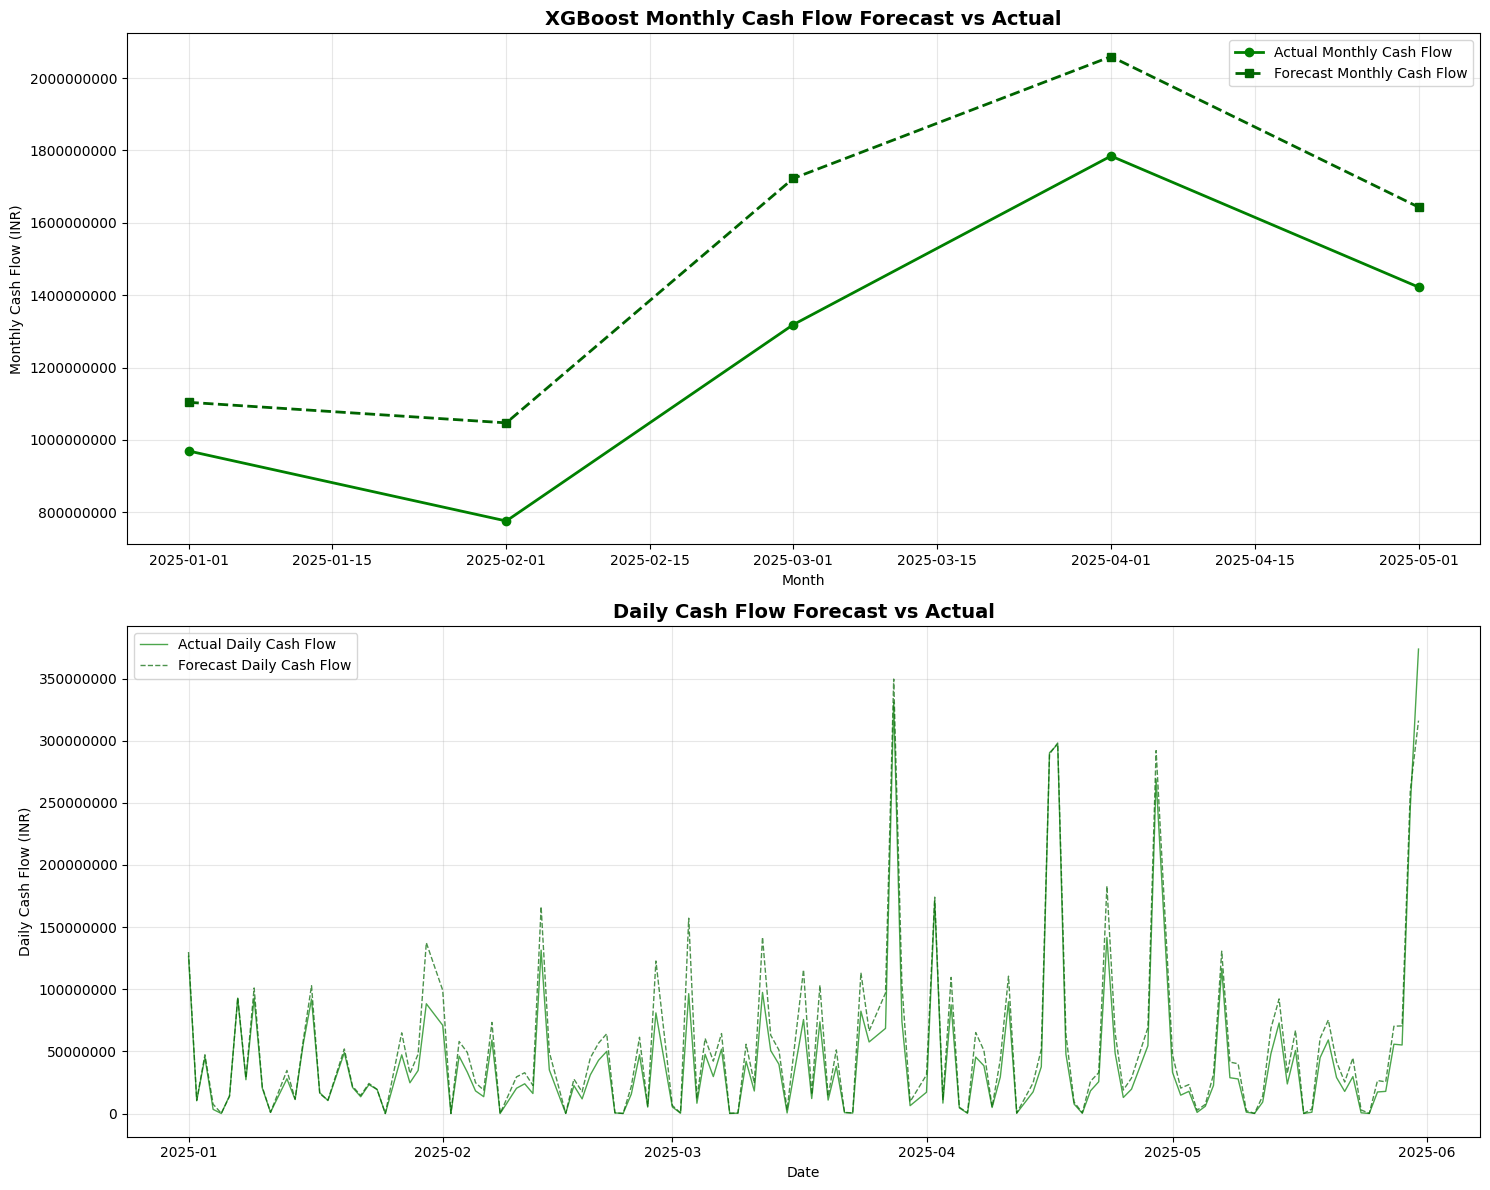


📈 Cash Flow Forecast Performance Metrics:
MAE (Mean Absolute Error): ₹261,266,165.24
RMSE (Root Mean Square Error): ₹275,576,696.44
MAPE (Mean Absolute Percentage Error): 22.10%
✅ Cash Flow Forecast Accuracy: 77.90%


📊 Top 15 Most Important Features for Cash Flow Prediction:
| feature                     |   importance |
|:----------------------------|-------------:|
| cashflow_ratio_to_max       |       0.3471 |
| year                        |       0.1328 |
| days_to_month_end           |       0.0784 |
| historical_quarter_cashflow |       0.0691 |
| days_since_start            |       0.0634 |
| is_month_end                |       0.0527 |
| cashflow_ratio_to_min       |       0.0406 |
| historical_dow_cashflow     |       0.0257 |
| cashflow_growth_7d          |       0.0222 |
| historical_month_cashflow   |       0.0161 |
| cashflow_rolling_max_90     |       0.0151 |
| cashflow_rolling_mean_90    |       0.0144 |
| cashflow_growth_30d         |       0.0121 |
| is_quarter_end 

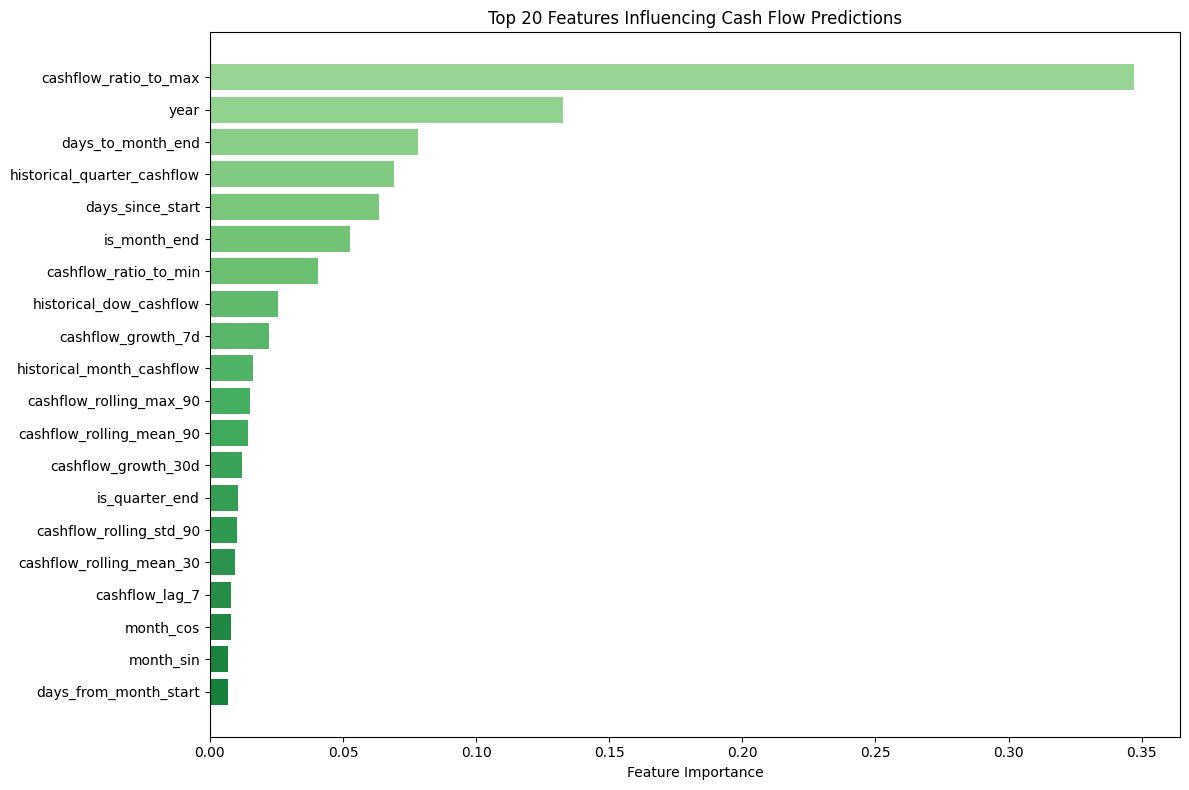

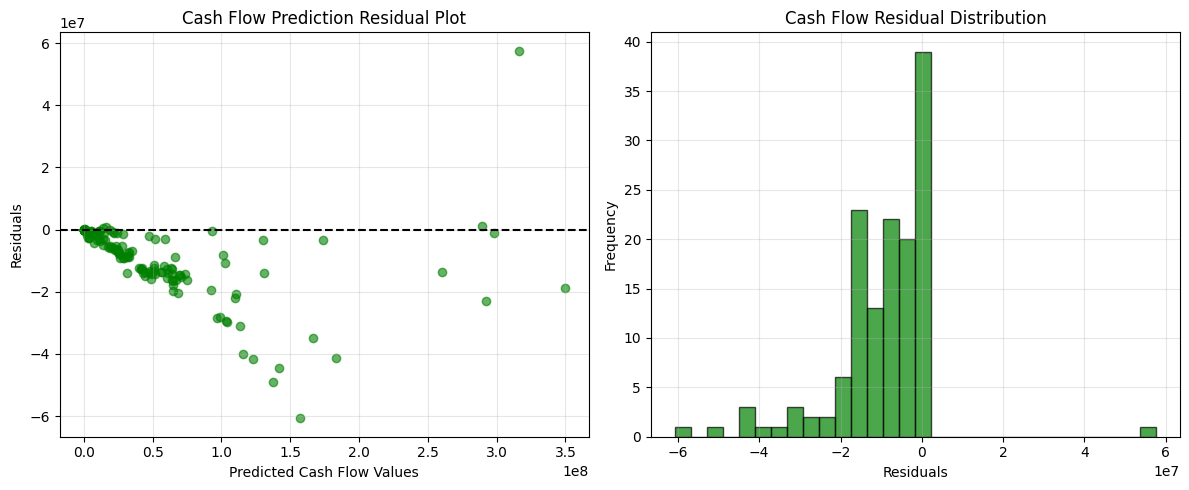


📊 Cash Flow Residual Statistics:
Mean Residual: ₹-9,466,165.99
Std Residual: ₹12,498,000.48
Min Residual: ₹-60,731,244.96
Max Residual: ₹57,581,659.30

💡 Cash Flow Forecasting Insights:
Total Actual Cash Flow: ₹6,270,508,853.82
Total Forecast Cash Flow: ₹7,576,839,680.00
Total Difference: ₹1,306,330,826.18
✅ Good cash flow forecast accuracy!

🎯 Cash Flow Model is ready to predict future cash flows!
Use this model for: Liquidity management, Investment planning, Financial strategy


In [ ]:
# CASH FLOW FORECASTING MODEL
# Predicts company cash flow using XGBoost

# IMPORTANT: Please ensure you have the following Python libraries installed
# in your Gemini environment BEFORE running this script:
# - openpyxl
# - xgboost
# - scikit-learn
# - pandas
# - numpy
# - matplotlib
# - tabulate
# If any are missing, you may need to install them via your environment's package manager.

# STEP 1: Upload file
from google.colab import files

print("Please upload your 'Predictive_Analysis_Final.xlsx - Sheet1.csv' file.")
uploaded = files.upload()

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 3: Load Data
if not uploaded:
    print("No file was uploaded. Please upload the required file to proceed.")
    # In a real interactive session, you might re-prompt or exit.
    # For this environment, we'll indicate an error and proceed carefully
    # or stop if no file is available to prevent further errors.
    raise ValueError("No file uploaded. Cannot proceed with analysis.")


file_path = list(uploaded.keys())[0]
print(f"File '{file_path}' uploaded successfully.")

try:
    # Attempt to load as Excel first, as the original file was .xlsx
    df = pd.read_excel(file_path, engine="openpyxl")
    print("Successfully loaded file as an Excel file.")
except Exception as e:
    print(f"Error loading the file as an Excel file: {e}")
    print("Attempting to load as CSV instead...")
    try:
        df = pd.read_csv(file_path)
        print("Successfully loaded file as CSV.")
    except Exception as csv_e:
        print(f"Error loading the file as CSV: {csv_e}")
        print("Please ensure the file is correctly formatted (Excel or CSV) and named.")
        raise RuntimeError("Failed to load data from the provided file. Check format and content.")


print("\n📋 Dataset Overview:")
print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nAccount Base Types available: {df['Account Base Type'].unique()}")
print(f"Currency Codes available: {df['Currency Code'].unique()}")
# Check for 'Cash Flow - Type' and 'Cash Flow Type'
if 'Cash Flow - Type' in df.columns:
    print(f"Cash Flow - Type values available: {df['Cash Flow - Type'].unique()}")
if 'Cash Flow Type' in df.columns:
    print(f"Cash Flow Type values available: {df['Cash Flow Type'].unique()}")


# STEP 4: Filter for Cash Flow records and prepare amount
# Use 'Credit - Debit' as the amount value
# Filter by non-null values in 'Cash Flow - Type' or 'Cash Flow Type'
cashflow_df = df[df['Cash Flow - Type'].notna() | df['Cash Flow Type'].notna()].copy()

print(f"\n💰 Cash Flow Data Overview:")
print(f"Total cash flow records: {len(cashflow_df):,}")

if len(cashflow_df) == 0:
    print("❌ No cash flow records found! Please ensure your data has non-null values in 'Cash Flow - Type' or 'Cash Flow Type' columns.")
    raise ValueError("No relevant cash flow data found. Cannot proceed with forecasting.")
else:
    cashflow_df['Transaction Date'] = pd.to_datetime(cashflow_df['Transaction Date'])
    # Use 'Credit - Debit' as the amount for cash flow
    cashflow_df['Credit - Debit'] = pd.to_numeric(cashflow_df['Credit - Debit'], errors='coerce')
    cashflow_df.dropna(subset=['Credit - Debit'], inplace=True)
    cashflow_df['Cash Flow Amount'] = cashflow_df['Credit - Debit'].abs() # Use absolute for total flow

    print(f"Date range: {cashflow_df['Transaction Date'].min()} to {cashflow_df['Transaction Date'].max()}")
    print(f"Total cash flow amount: ₹{cashflow_df['Cash Flow Amount'].sum():,.2f}")
    print(f"Average daily cash flow: ₹{cashflow_df['Cash Flow Amount'].mean():,.2f}")

# STEP 5: Daily aggregation with data quality checks
daily_cashflow = cashflow_df.groupby('Transaction Date')['Cash Flow Amount'].sum().reset_index()
daily_cashflow.columns = ['ds', 'y']
daily_cashflow = daily_cashflow[daily_cashflow['ds'] >= '2015-01-01'].copy() # Adjust start date if needed

# Remove extreme outliers (beyond 3 standard deviations)
if len(daily_cashflow) > 1 and daily_cashflow['y'].std() > 0:
    mean_val = daily_cashflow['y'].mean()
    std_val = daily_cashflow['y'].std()
    daily_cashflow = daily_cashflow[np.abs(daily_cashflow['y'] - mean_val) <= 3 * std_val].copy()

print(f"\n📊 Daily Cash Flow Summary:")
print(f"Total days with cash flow: {len(daily_cashflow):,}")
print(f"Average daily cash flow: ₹{daily_cashflow['y'].mean():,.2f}")
print(f"Median daily cash flow: ₹{daily_cashflow['y'].median():,.2f}")
print(f"Max daily cash flow: ₹{daily_cashflow['y'].max():,.2f}")

# STEP 6: Enhanced Feature Engineering for Cash Flow
def create_cashflow_features(df_input):
    df_temp = df_input.copy()

    # Basic date features
    df_temp['day'] = df_temp['ds'].dt.day
    df_temp['month'] = df_temp['ds'].dt.month
    df_temp['year'] = df_temp['ds'].dt.year
    df_temp['dayofweek'] = df_temp['ds'].dt.dayofweek
    df_temp['quarter'] = df_temp['ds'].dt.quarter

    # Cyclical encoding for seasonal cash flow patterns
    df_temp['month_sin'] = np.sin(2 * np.pi * df_temp['month'] / 12)
    df_temp['month_cos'] = np.cos(2 * np.pi * df_temp['month'] / 12)
    df_temp['day_sin'] = np.sin(2 * np.pi * df_temp['day'] / 31)
    df_temp['day_cos'] = np.cos(2 * np.pi * df_temp['day'] / 31)
    df_temp['dayofweek_sin'] = np.sin(2 * np.pi * df_temp['dayofweek'] / 7)
    df_temp['dayofweek_cos'] = np.cos(2 * np.pi * df_temp['dayofweek'] / 7)

    # Business calendar features
    df_temp['is_month_end'] = df_temp['ds'].dt.is_month_end.astype(int)
    df_temp['is_month_start'] = df_temp['ds'].dt.is_month_start.astype(int)
    df_temp['is_quarter_end'] = df_temp['ds'].dt.is_quarter_end.astype(int)
    df_temp['is_year_end'] = ((df_temp['month'] == 12) & (df_temp['day'] >= 25)).astype(int)
    df_temp['is_fy_end'] = (df_temp['month'] == 3).astype(int) # Financial year end in India
    df_temp['is_weekend'] = (df_temp['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df_temp['days_from_month_start'] = df_temp['day'] - 1
    df_temp['days_to_month_end'] = df_temp['ds'].dt.days_in_month - df_temp['day']

    # Lag features (cash flow history patterns)
    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
        df_temp[f'cashflow_lag_{lag}'] = df_temp['y'].shift(lag)

    # Rolling statistics for cash flow trends
    for window in [7, 14, 30, 90]:
        df_temp[f'cashflow_rolling_mean_{window}'] = df_temp['y'].rolling(window, min_periods=1).mean().shift(1)
        df_temp[f'cashflow_rolling_std_{window}'] = df_temp['y'].rolling(window, min_periods=1).std().shift(1)
        df_temp[f'cashflow_rolling_max_{window}'] = df_temp['y'].rolling(window, min_periods=1).max().shift(1)
        df_temp[f'cashflow_rolling_min_{window}'] = df_temp['y'].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    df_temp['historical_month_cashflow'] = df_temp.groupby('month')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_quarter_cashflow'] = df_temp.groupby('quarter')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_dow_cashflow'] = df_temp.groupby('dayofweek')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Cash flow volatility features
    df_temp['cashflow_volatility_7d'] = df_temp['y'].rolling(7).std().shift(1)
    df_temp['cashflow_volatility_30d'] = df_temp['y'].rolling(30).std().shift(1)

    # Cash flow growth rates - Handle division by zero
    df_temp['cashflow_growth_7d'] = ((df_temp['y'] / df_temp['y'].shift(7).replace(0, np.nan)) - 1) * 100
    df_temp['cashflow_growth_30d'] = ((df_temp['y'] / df_temp['y'].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df_temp['days_since_start'] = (df_temp['ds'] - df_temp['ds'].min()).dt.days

    # Cash flow ratios and patterns - Handle division by zero
    epsilon = 1e-6
    df_temp['cashflow_ratio_to_max'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).max().shift(1) + epsilon)
    df_temp['cashflow_ratio_to_min'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).min().shift(1) + epsilon)

    return df_temp

# Apply feature engineering
daily_cashflow_features = create_cashflow_features(daily_cashflow)

# Critical: Replace inf values with NaN and then fill NaNs.
daily_cashflow_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_cashflow_features.fillna(method='bfill', inplace=True)
daily_cashflow_features.fillna(method='ffill', inplace=True)
daily_cashflow_features.fillna(0, inplace=True)

# STEP 7: Split train/test
train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < '2025-01-01'].copy()
test_cashflow = daily_cashflow_features[(daily_cashflow_features['ds'] >= '2025-01-01') &
                                      (daily_cashflow_features['ds'] <= '2025-05-31')].copy()

# Select features (excluding target and date columns)
feature_cols_cashflow = [col for col in daily_cashflow_features.columns if col not in ['ds', 'y']]

print(f"\n🎯 Model Training Setup (Cash Flow):")
print(f"Training data shape: {train_cashflow.shape}")
print(f"Test data shape: {test_cashflow.shape}")
print(f"Number of features: {len(feature_cols_cashflow)}")

if len(test_cashflow) == 0:
    print("❌ No test data available for 2025. Adjusting date range...")
    # Use last 6 months as test data if no 2025 data exists
    test_start_date_cashflow = daily_cashflow_features['ds'].max() - pd.DateOffset(months=6)
    train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < test_start_date_cashflow].copy()
    test_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] >= test_start_date_cashflow].copy()
    print(f"Adjusted - Training until: {test_start_date_cashflow}")
    print(f"Testing from: {test_start_date_cashflow} to {daily_cashflow_features['ds'].max()}")

if train_cashflow.empty or test_cashflow.empty:
    raise ValueError("Insufficient data for training or testing after splitting. Please check your dataset and date ranges.")

# STEP 8: Train Cash Flow forecasting model
model_cashflow = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("🚀 Training cash flow forecasting model...")
model_cashflow.fit(train_cashflow[feature_cols_cashflow], train_cashflow['y'])

# STEP 9: Make cash flow predictions
test_pred_cashflow = test_cashflow.copy()
test_pred_cashflow['cashflow_forecast'] = model_cashflow.predict(test_cashflow[feature_cols_cashflow])
test_pred_cashflow['cashflow_forecast'] = test_pred_cashflow['cashflow_forecast'].clip(lower=0) # Ensure predictions are non-negative

# STEP 10: Monthly aggregation for comparison
monthly_actual_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['y'].sum()
monthly_forecast_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['cashflow_forecast'].sum()

# STEP 11: Calculate cash flow forecast metrics
def safe_mape(actual, forecast):
    mask = actual != 0
    if mask.sum() == 0:
        return 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mae_cashflow = mean_absolute_error(monthly_actual_cashflow, monthly_forecast_cashflow)
rmse_cashflow = np.sqrt(mean_squared_error(monthly_actual_cashflow, monthly_forecast_cashflow))
mape_cashflow = safe_mape(monthly_actual_cashflow.values, monthly_forecast_cashflow.values)
accuracy_cashflow = 100 - mape_cashflow

# STEP 12: Create monthly cash flow comparison table
comparison_df_cashflow = pd.concat([monthly_actual_cashflow, monthly_forecast_cashflow], axis=1)
comparison_df_cashflow.columns = ['Actual Cash Flow (INR)', 'Forecast Cash Flow (INR)']
comparison_df_cashflow['Error'] = comparison_df_cashflow['Actual Cash Flow (INR)'] - comparison_df_cashflow['Forecast Cash Flow (INR)']
comparison_df_cashflow['Absolute % Error'] = (comparison_df_cashflow['Error'].abs() /
                                              comparison_df_cashflow['Actual Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
comparison_df_cashflow.index = comparison_df_cashflow.index.to_timestamp()

print("\n💸 Monthly Cash Flow Forecast Summary Table:")
print(comparison_df_cashflow.round(2).to_markdown(index=True))

# NEW STEP: Daily Cash Flow Comparison Table
print("\n🗓️ Daily Cash Flow Forecast Summary Table:")
daily_comparison_df_cashflow = test_pred_cashflow[['ds', 'y', 'cashflow_forecast']].copy()
daily_comparison_df_cashflow.columns = ['Date', 'Actual Daily Cash Flow (INR)', 'Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Error'] = daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'] - daily_comparison_df_cashflow['Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Absolute % Error'] = (daily_comparison_df_cashflow['Error'].abs() /
                                                   daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
print(daily_comparison_df_cashflow.round(2).to_markdown(index=False))

# STEP 13: Cash Flow Visualization (Optional - user requested table, but good to keep visualization code for reference)
# The user specifically requested a table, but we will still show the plots as a comprehensive output.
# If you only want tables, you can comment out the plt.show() lines.
fig_cashflow, (ax1_cashflow, ax2_cashflow) = plt.subplots(2, 1, figsize=(15, 12))

# Monthly cash flow comparison
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Actual Cash Flow (INR)'],
         label='Actual Monthly Cash Flow', color='green', linewidth=2, marker='o')
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Forecast Cash Flow (INR)'],
         label='Forecast Monthly Cash Flow', color='darkgreen', linewidth=2,
         linestyle='--', marker='s')
ax1_cashflow.set_title("XGBoost Monthly Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax1_cashflow.set_xlabel("Month")
ax1_cashflow.set_ylabel("Monthly Cash Flow (INR)")
ax1_cashflow.legend()
ax1_cashflow.grid(True, alpha=0.3)
ax1_cashflow.ticklabel_format(style='plain', axis='y')

# Daily cash flow comparison for detailed view
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['y'], label='Actual Daily Cash Flow',
         color='green', alpha=0.7, linewidth=1)
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['cashflow_forecast'], label='Forecast Daily Cash Flow',
         color='darkgreen', alpha=0.7, linewidth=1, linestyle='--')
ax2_cashflow.set_title("Daily Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax2_cashflow.set_xlabel("Date")
ax2_cashflow.set_ylabel("Daily Cash Flow (INR)")
ax2_cashflow.legend()
ax2_cashflow.grid(True, alpha=0.3)
ax2_cashflow.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# STEP 14: Cash Flow forecast performance metrics
print(f"\n📈 Cash Flow Forecast Performance Metrics:")
print(f"MAE (Mean Absolute Error): ₹{mae_cashflow:,.2f}")
print(f"RMSE (Root Mean Square Error): ₹{rmse_cashflow:,.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_cashflow:.2f}%")
print(f"✅ Cash Flow Forecast Accuracy: {accuracy_cashflow:.2f}%\n")

# STEP 15: Feature importance analysis for Cash Flow
feature_importance_cashflow = pd.DataFrame({
    'feature': feature_cols_cashflow,
    'importance': model_cashflow.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features for Cash Flow Prediction:")
print(feature_importance_cashflow.head(15).round(4).to_markdown(index=False))

# Plot cash flow feature importance
plt.figure(figsize=(12, 8))
top_features_cashflow = feature_importance_cashflow.head(20)
colors_cashflow = plt.cm.Greens(np.linspace(0.4, 0.8, len(top_features_cashflow)))
plt.barh(range(len(top_features_cashflow)), top_features_cashflow['importance'], color=colors_cashflow)
plt.yticks(range(len(top_features_cashflow)), top_features_cashflow['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Influencing Cash Flow Predictions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 16: Cash Flow residual analysis
residuals_cashflow = test_pred_cashflow['y'] - test_pred_cashflow['cashflow_forecast']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_pred_cashflow['cashflow_forecast'], residuals_cashflow, alpha=0.6, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Cash Flow Values')
plt.ylabel('Residuals')
plt.title('Cash Flow Prediction Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals_cashflow, bins=30, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Cash Flow Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Cash Flow Residual Statistics:")
print(f"Mean Residual: ₹{residuals_cashflow.mean():,.2f}")
print(f"Std Residual: ₹{residuals_cashflow.std():,.2f}")
print(f"Min Residual: ₹{residuals_cashflow.min():,.2f}")
print(f"Max Residual: ₹{residuals_cashflow.max():,.2f}")

# STEP 17: Summary insights
print(f"\n💡 Cash Flow Forecasting Insights:")
total_actual_cashflow = monthly_actual_cashflow.sum()
total_forecast_cashflow = monthly_forecast_cashflow.sum()
print(f"Total Actual Cash Flow: ₹{total_actual_cashflow:,.2f}")
print(f"Total Forecast Cash Flow: ₹{total_forecast_cashflow:,.2f}")
print(f"Total Difference: ₹{abs(total_actual_cashflow - total_forecast_cashflow):,.2f}")

if accuracy_cashflow > 70:
    print("✅ Good cash flow forecast accuracy!")
elif accuracy_cashflow > 50:
    print("⚠️ Moderate cash flow forecast accuracy - consider more data or features")
else:
    print("❌ Low cash flow forecast accuracy - model needs improvement")

print(f"\n🎯 Cash Flow Model is ready to predict future cash flows!")
print(f"Use this model for: Liquidity management, Investment planning, Financial strategy")


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Step 1: Load the Excel file
def load_excel_data(file_path):
    """
    Load Excel file into pandas DataFrame
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Step 2: Process Income and Expense data - INDIVIDUAL TRANSACTIONS
def process_income_expense(df, account_type_col='account_base_type',
                          date_col='transaction_date',
                          amount_col='amount'):
    """
    Extract income and expense rows, convert each to profit entries
    """
    # Get unique account types to check available values
    unique_types = df[account_type_col].unique()
    print(f"Available account types: {unique_types}")

    # Create case-insensitive filter for income and expense
    income_expense_df = df[df[account_type_col].str.lower().isin(['income', 'expense'])].copy()

    if income_expense_df.empty:
        print("No income or expense records found!")
        print("Make sure your data contains 'Income' and 'Expense' account types")
        return None

    print(f"Found {len(income_expense_df)} income/expense records")
    print(f"Income records: {len(income_expense_df[income_expense_df[account_type_col].str.lower() == 'income'])}")
    print(f"Expense records: {len(income_expense_df[income_expense_df[account_type_col].str.lower() == 'expense'])}")

    # Ensure date column is datetime
    income_expense_df[date_col] = pd.to_datetime(income_expense_df[date_col])

    # Convert each income/expense row to profit calculation
    # Income = positive profit, Expense = negative profit
    income_expense_df['profit'] = income_expense_df.apply(
        lambda row: row[amount_col] if row[account_type_col].lower() == 'income'
                   else -row[amount_col] if row[account_type_col].lower() == 'expense'
                   else 0, axis=1
    )

    print(f"Profit calculation completed for {len(income_expense_df)} individual transactions")
    print(f"Total profit: {income_expense_df['profit'].sum():.2f}")
    print(f"Positive profits (income): {len(income_expense_df[income_expense_df['profit'] > 0])}")
    print(f"Negative profits (expense): {len(income_expense_df[income_expense_df['profit'] < 0])}")

    return income_expense_df

# Step 3: Prepare profit rows for merging
def create_profit_rows(income_expense_df, date_col='transaction_date', original_df_columns=None):
    """
    Convert each income/expense transaction to profit rows maintaining original structure
    """
    if income_expense_df is None or income_expense_df.empty:
        return pd.DataFrame()

    profit_rows = []

    for _, row in income_expense_df.iterrows():
        # Create profit row maintaining original column structure
        profit_row = {}

        # Copy relevant columns from original row
        if original_df_columns:
            for col in original_df_columns:
                if col in row.index:
                    profit_row[col] = row[col]

        # Override specific columns for profit entry
        profit_row[date_col] = row[date_col]
        profit_row['Account Base Type'] = 'Profit'
        profit_row['Credit - Debit'] = row['profit']
        profit_row['Account Name'] = f"Profit from {row.get('Account Name', 'Transaction')} - {row[date_col].strftime('%Y-%m-%d')}"
        profit_row['Account Type'] = 'Profit'

        profit_rows.append(profit_row)

    profit_df = pd.DataFrame(profit_rows)
    print(f"Created {len(profit_df)} individual profit rows")
    print(f"Total profit amount: {profit_df['Credit - Debit'].sum():.2f}")

    return profit_df

# Step 4: Merge back with assets and liabilities
def merge_with_assets_liabilities_equity(original_df, profit_df, account_type_col='account_base_type'):
    """
    Filter assets, liabilities, and equity from original data and append profit rows
    """
    # Filter assets, liabilities, and equity (case-insensitive)
    balance_sheet_df = original_df[
        original_df[account_type_col].str.lower().isin(['asset', 'liability', 'assets', 'liabilities', 'equity'])
    ].copy()

    print(f"Found {len(balance_sheet_df)} asset/liability/equity records")
    print(f"Breakdown: {balance_sheet_df[account_type_col].value_counts()}")

    # Append profit rows
    final_df = pd.concat([balance_sheet_df, profit_df], ignore_index=True)

    print(f"Final dataset shape: {final_df.shape}")
    print(f"Account types in final dataset: {final_df[account_type_col].value_counts()}")

    return final_df

# Main processing function
def process_cashflow_data(file_path,
                         account_type_col='account_base_type',
                         date_col='transaction_date',
                         amount_col='amount',
                         credit_debit_col='credit_debit'):
    """
    Complete processing pipeline for cashflow data preparation
    """
    print("=== Starting Cashflow Data Processing ===\n")

    # Step 1: Load data
    df = load_excel_data(file_path)
    if df is None:
        return None

    # Display initial data info
    print(f"\nInitial data overview:")
    print(f"Account types: {df[account_type_col].value_counts()}")

    # Step 2: Process income and expense - INDIVIDUAL TRANSACTIONS
    income_expense_data = process_income_expense(df, account_type_col, date_col, amount_col)
    if income_expense_data is None:
        return None

    # Step 3: Create individual profit rows for each income/expense transaction
    profit_rows_df = create_profit_rows(income_expense_data, date_col, df.columns.tolist())
    print(f"\nCreated {len(profit_rows_df)} individual profit rows (should match income + expense count)")
    print(f"Expected: {len(income_expense_data)} profit rows")

    # Step 4: Merge with assets, liabilities, and equity
    final_cashflow_df = merge_with_assets_liabilities_equity(df, profit_rows_df, account_type_col)

    print("\n=== Processing Complete ===")
    return final_cashflow_df, income_expense_data

# Usage example and helper functions
def save_results(final_df, profit_table, output_path='cashflow_data.xlsx'):
    """
    Save the processed data to Excel file
    """
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        final_df.to_excel(writer, sheet_name='Cashflow_Data', index=False)
        profit_table.to_excel(writer, sheet_name='Profit_Summary', index=False)

    print(f"Results saved to {output_path}")

def display_summary(final_df, account_type_col='account_base_type'):
    """
    Display summary statistics of the final dataset
    """
    print("\n=== FINAL DATASET SUMMARY ===")
    print(f"Total records: {len(final_df)}")
    print(f"\nAccount type distribution:")
    print(final_df[account_type_col].value_counts())

    if 'credit_debit' in final_df.columns:
        print(f"\nCredit/Debit summary:")
        print(f"Total Credits: {final_df['credit_debit'].sum():.2f}")
        print(f"Non-zero entries: {(final_df['credit_debit'] != 0).sum()}")

# Google Colab File Upload and Processing
def upload_and_process_excel():
    """
    Upload Excel file in Google Colab and process it
    """
    from google.colab import files
    import os

    print("Please upload your Excel file:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return None, None

    # Get the uploaded file path
    file_name = list(uploaded.keys())[0]
    file_path = f"/content/{file_name}"

    print(f"File uploaded: {file_name}")

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found at {file_path}")
        return None, None

    # Load and inspect the data first
    try:
        df = pd.read_excel(file_path)
        print(f"\nFile loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\nFirst few rows:")
        print(df.head())

        # Show unique values in account type column (if it exists)
        possible_account_cols = [col for col in df.columns if 'account' in col.lower() or 'type' in col.lower()]
        if possible_account_cols:
            print(f"\nPossible account type columns: {possible_account_cols}")
            for col in possible_account_cols:
                print(f"\nUnique values in '{col}': {df[col].unique()}")

        return file_path, df

    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None, None

# Interactive setup function
def interactive_setup():
    """
    Interactive setup to identify correct column names
    """
    file_path, df = upload_and_process_excel()

    if df is None:
        return None, None

    print("\n" + "="*50)
    print("COLUMN IDENTIFICATION")
    print("="*50)

    # Get column names from user
    print(f"Available columns: {list(df.columns)}")

    account_type_col = input("\nEnter the column name for account base type (contains income, expense, asset, liabilities): ").strip()
    date_col = input("Enter the column name for transaction date: ").strip()
    amount_col = input("Enter the column name for amount/value: ").strip()

    # Validate columns exist
    missing_cols = []
    for col_name, col_var in [("Account type", account_type_col), ("Date", date_col), ("Amount", amount_col)]:
        if col_var not in df.columns:
            missing_cols.append(f"{col_name}: '{col_var}'")

    if missing_cols:
        print(f"\nError: The following columns were not found:")
        for missing in missing_cols:
            print(f"  - {missing}")
        print(f"\nAvailable columns: {list(df.columns)}")
        return None, None

    # Show data preview with selected columns
    print(f"\nData preview with selected columns:")
    print(df[[account_type_col, date_col, amount_col]].head())

    # Check account types
    print(f"\nUnique account types found: {df[account_type_col].unique()}")

    return file_path, {
        'account_type_col': account_type_col,
        'date_col': date_col,
        'amount_col': amount_col
    }

# Main execution function for Google Colab
def run_cashflow_processing():
    """
    Main function to run the entire cashflow processing pipeline
    """
    print("=== CASHFLOW DATA PROCESSING ===\n")

    # Interactive setup
    file_path, column_config = interactive_setup()

    if file_path is None or column_config is None:
        print("Setup failed. Please try again.")
        return

    # Process the data
    try:
        result = process_cashflow_data(
            file_path=file_path,
            account_type_col=column_config['account_type_col'],
            date_col=column_config['date_col'],
            amount_col=column_config['amount_col']
        )

        if result is None:
            print("Processing failed!")
            return

        final_df, profit_summary = result

        # Display summary
        display_summary(final_df, column_config['account_type_col'])

        # Save results
        output_file = 'processed_cashflow_data.xlsx'
        save_results(final_df, profit_summary, output_file)

        # Display first few rows
        print("\nFirst 10 rows of final dataset:")
        print(final_df.head(10))

        # Download the processed file
        from google.colab import files
        files.download(output_file)

        print(f"\n✅ Processing complete! Downloaded: {output_file}")

        return final_df, profit_summary

    except Exception as e:
        print(f"Error during processing: {e}")
        return None

# Quick start function
def quick_start_with_defaults(file_path):
    """
    Quick start with common default column names
    """
    common_configs = [
        {'account_type_col': 'account_base_type', 'date_col': 'transaction_date', 'amount_col': 'amount'},
        {'account_type_col': 'Account Type', 'date_col': 'Date', 'amount_col': 'Amount'},
        {'account_type_col': 'account_type', 'date_col': 'date', 'amount_col': 'value'},
    ]

    df = pd.read_excel(file_path)
    print(f"Columns in your file: {list(df.columns)}")

    for i, config in enumerate(common_configs):
        missing = [col for col in config.values() if col not in df.columns]
        if not missing:
            print(f"✅ Using configuration {i+1}: {config}")
            return process_cashflow_data(file_path, **config)
        else:
            print(f"❌ Configuration {i+1} missing columns: {missing}")

    print("No matching configuration found. Please use interactive_setup() or run_cashflow_processing()")
    return None

# Example usage
if __name__ == "__main__":
    # Run the complete interactive processing
    run_cashflow_processing()

=== CASHFLOW DATA PROCESSING ===

Please upload your Excel file:


Saving Predictive_Analysis_Final.xlsx to Predictive_Analysis_Final (3).xlsx
File uploaded: Predictive_Analysis_Final (3).xlsx

File loaded successfully!
Shape: (416877, 10)
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

First few rows:
   Credit - Debit Currency Code  Debit - Credit       Zoho Module  \
0       -648339.0           INR        648339.0  customer_payment   
1       -119770.0           INR        119770.0  customer_payment   
2       -259508.0           INR        259508.0  customer_payment   
3             0.5           INR            -0.5   invoice_payment   
4        229758.5           INR       -229758.5   invoice_payment   

  Transaction Date                      Account Name Account Base Type  \
0       2018-02-20  PCA_Customer_JN and WDP(JRN)_INR             Asset   
1       2018-02-19  PCA_Customer_JN and WDP(JRN)_INR      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Processing complete! Downloaded: processed_cashflow_data.xlsx


Please upload your 'Predictive_Analysis_Final.xlsx - Sheet1.csv' file.


Saving processed_cashflow_data(2).xlsx to processed_cashflow_data(2).xlsx
File 'processed_cashflow_data(2).xlsx' uploaded successfully.
Successfully loaded file as an Excel file.

📋 Dataset Overview:
Total records: 416,877
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

Account Base Types available: ['Asset' 'Liability' 'Equity' 'Profit']
Currency Codes available: ['INR' 'USD' 'PHP' 'LKR' 'BHD' 'QAR' 'KWD' 'HKD' 'BDT' 'IDR' 'EGP' 'VND'
 'MYR' 'KRW' 'JPY' 'KHR' 'AED' 'SGD' 'MXN' 'JOD' 'OMR' 'KES' 'TZS' 'ZAR'
 'BGN' 'PLN' 'CNY' 'THB' 'NZD' 'AUD' 'GBP' 'EUR' 'CHF' 'SAR' 'MAD' 'UGX'
 'GEL' 'IRR' 'TWD' 'MMK' 'DOP' 'NPR' 'CAD' 'JMD' 'AZN' 'BRL' 'ETB' 'SEK'
 'NGN' 'HUF' 'TRY' 'XAF' 'XOF' 'AMD']
Cash Flow - Type values available: ['-1' 'A. Cash Flow From Operating Activities' '0'
 'B. Cash Flow From Investing Activities']
Cash Flow Type values available:

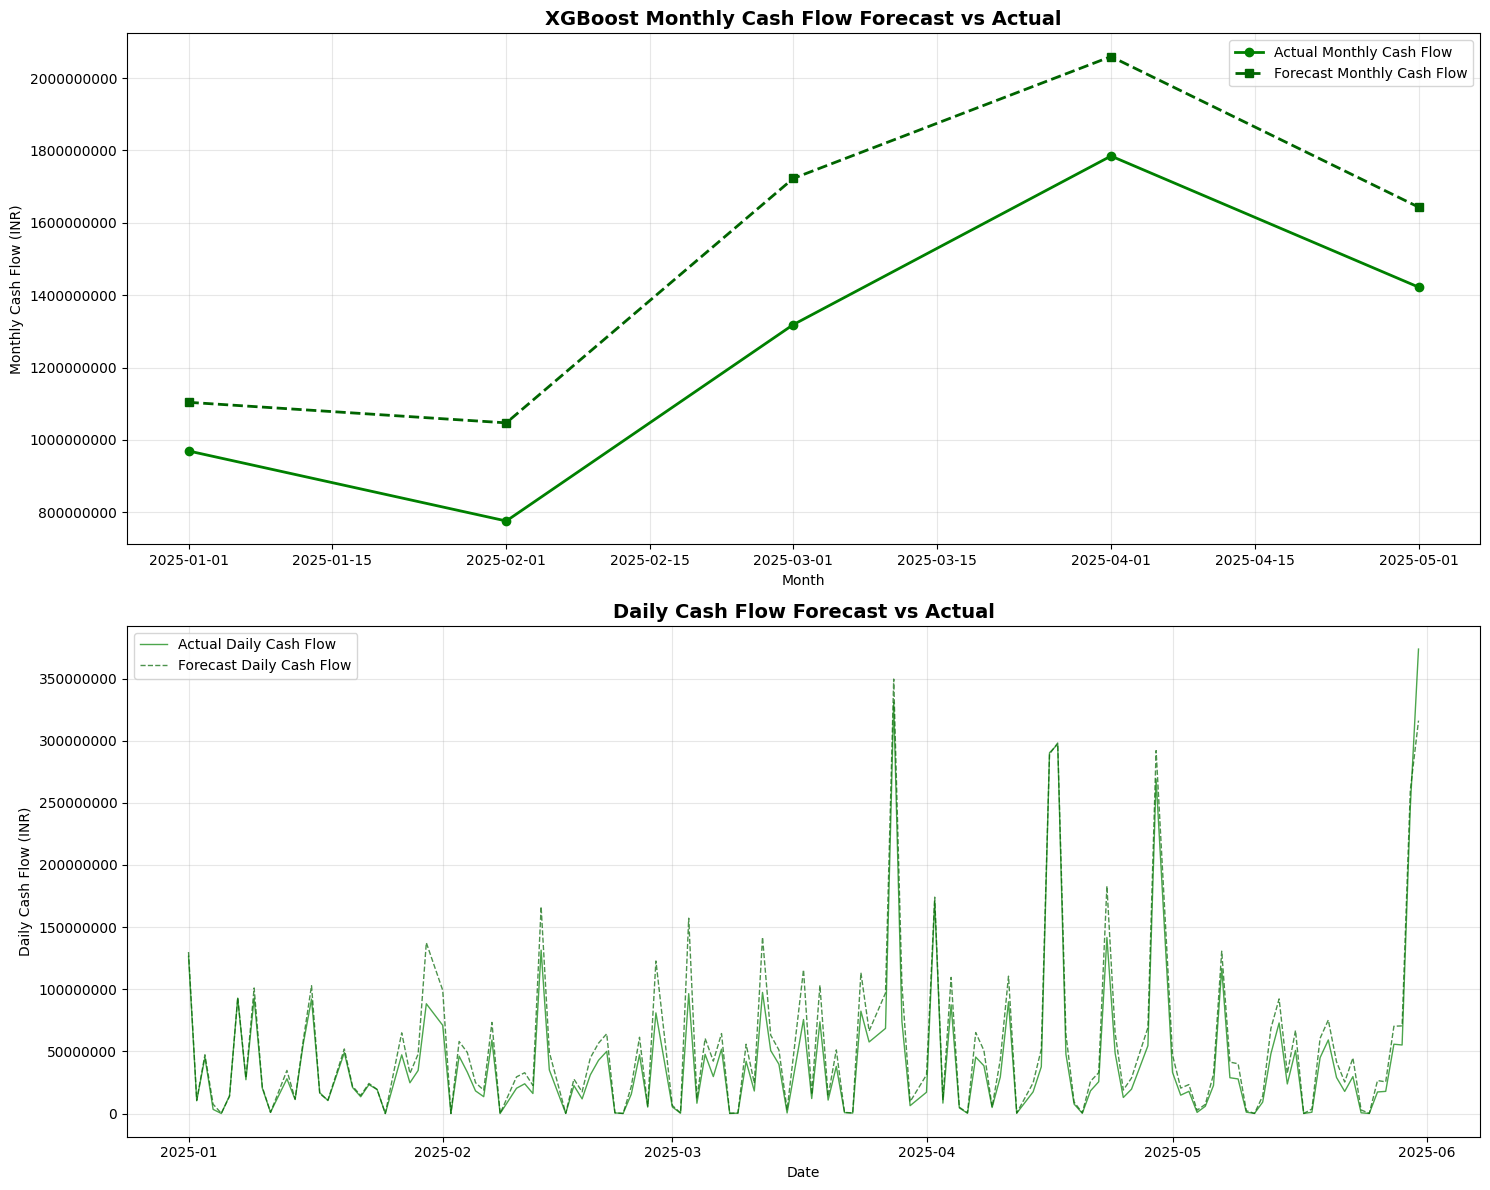


📈 Cash Flow Forecast Performance Metrics:
MAE (Mean Absolute Error): ₹261,266,165.24
RMSE (Root Mean Square Error): ₹275,576,696.44
MAPE (Mean Absolute Percentage Error): 22.10%
✅ Cash Flow Forecast Accuracy: 77.90%


📊 Top 15 Most Important Features for Cash Flow Prediction:
| feature                     |   importance |
|:----------------------------|-------------:|
| cashflow_ratio_to_max       |       0.3471 |
| year                        |       0.1328 |
| days_to_month_end           |       0.0784 |
| historical_quarter_cashflow |       0.0691 |
| days_since_start            |       0.0634 |
| is_month_end                |       0.0527 |
| cashflow_ratio_to_min       |       0.0406 |
| historical_dow_cashflow     |       0.0257 |
| cashflow_growth_7d          |       0.0222 |
| historical_month_cashflow   |       0.0161 |
| cashflow_rolling_max_90     |       0.0151 |
| cashflow_rolling_mean_90    |       0.0144 |
| cashflow_growth_30d         |       0.0121 |
| is_quarter_end 

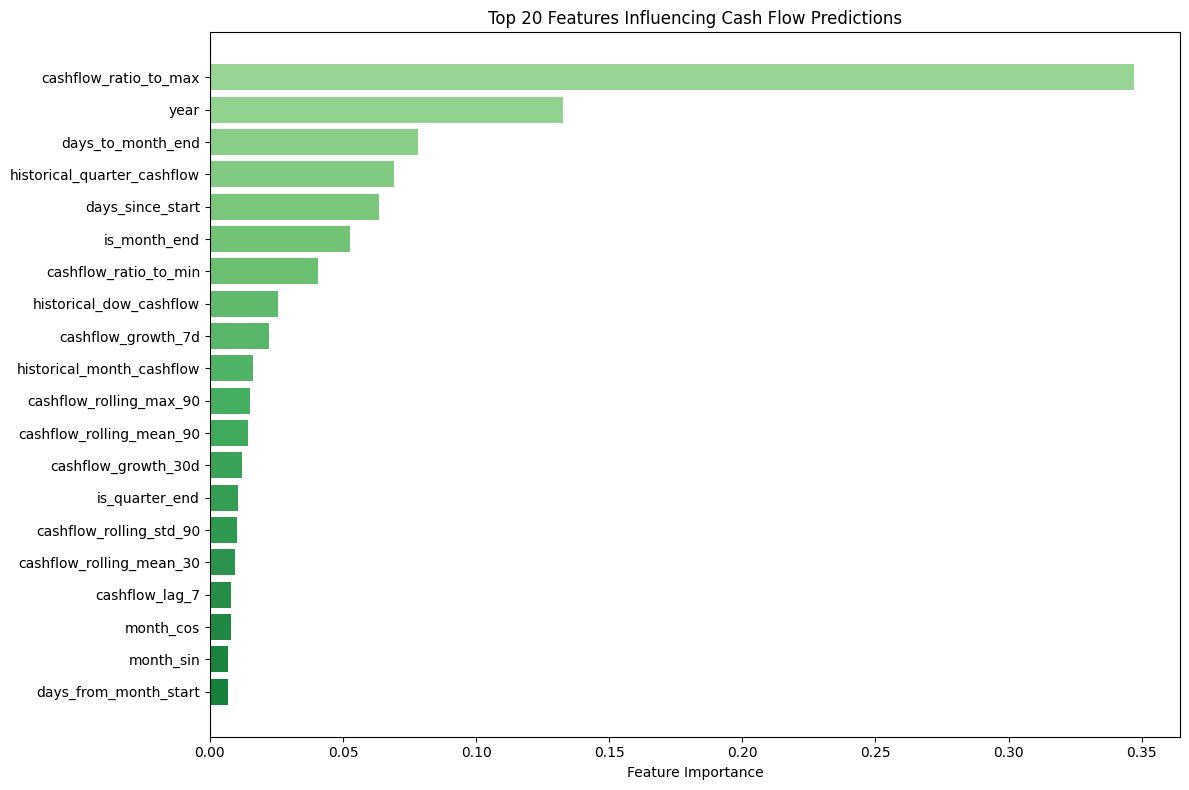

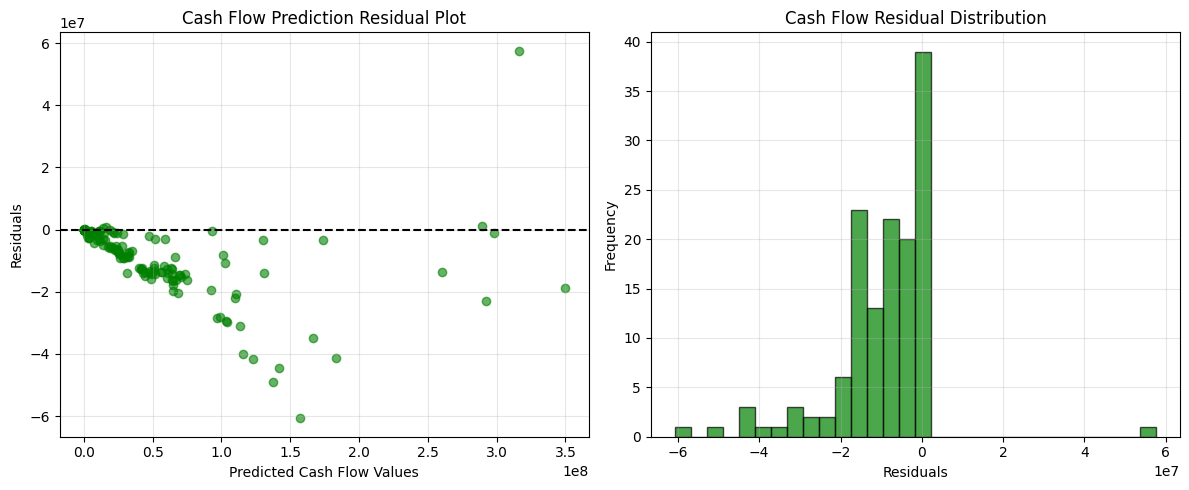


📊 Cash Flow Residual Statistics:
Mean Residual: ₹-9,466,165.99
Std Residual: ₹12,498,000.48
Min Residual: ₹-60,731,244.96
Max Residual: ₹57,581,659.30

💡 Cash Flow Forecasting Insights:
Total Actual Cash Flow: ₹6,270,508,853.82
Total Forecast Cash Flow: ₹7,576,839,680.00
Total Difference: ₹1,306,330,826.18
✅ Good cash flow forecast accuracy!

🎯 Cash Flow Model is ready to predict future cash flows!
Use this model for: Liquidity management, Investment planning, Financial strategy


In [ ]:
# CASH FLOW FORECASTING MODEL
# Predicts company cash flow using XGBoost

# IMPORTANT: Please ensure you have the following Python libraries installed
# in your Gemini environment BEFORE running this script:
# - openpyxl
# - xgboost
# - scikit-learn
# - pandas
# - numpy
# - matplotlib
# - tabulate
# If any are missing, you may need to install them via your environment's package manager.

# STEP 1: Upload file
from google.colab import files

print("Please upload your 'Predictive_Analysis_Final.xlsx - Sheet1.csv' file.")
uploaded = files.upload()

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 3: Load Data
if not uploaded:
    print("No file was uploaded. Please upload the required file to proceed.")
    # In a real interactive session, you might re-prompt or exit.
    # For this environment, we'll indicate an error and proceed carefully
    # or stop if no file is available to prevent further errors.
    raise ValueError("No file uploaded. Cannot proceed with analysis.")


file_path = list(uploaded.keys())[0]
print(f"File '{file_path}' uploaded successfully.")

try:
    # Attempt to load as Excel first, as the original file was .xlsx
    df = pd.read_excel(file_path, engine="openpyxl")
    print("Successfully loaded file as an Excel file.")
except Exception as e:
    print(f"Error loading the file as an Excel file: {e}")
    print("Attempting to load as CSV instead...")
    try:
        df = pd.read_csv(file_path)
        print("Successfully loaded file as CSV.")
    except Exception as csv_e:
        print(f"Error loading the file as CSV: {csv_e}")
        print("Please ensure the file is correctly formatted (Excel or CSV) and named.")
        raise RuntimeError("Failed to load data from the provided file. Check format and content.")


print("\n📋 Dataset Overview:")
print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nAccount Base Types available: {df['Account Base Type'].unique()}")
print(f"Currency Codes available: {df['Currency Code'].unique()}")
# Check for 'Cash Flow - Type' and 'Cash Flow Type'
if 'Cash Flow - Type' in df.columns:
    print(f"Cash Flow - Type values available: {df['Cash Flow - Type'].unique()}")
if 'Cash Flow Type' in df.columns:
    print(f"Cash Flow Type values available: {df['Cash Flow Type'].unique()}")


# STEP 4: Filter for Cash Flow records and prepare amount
# Use 'Credit - Debit' as the amount value
# Filter by non-null values in 'Cash Flow - Type' or 'Cash Flow Type'
cashflow_df = df[df['Cash Flow - Type'].notna() | df['Cash Flow Type'].notna()].copy()

print(f"\n💰 Cash Flow Data Overview:")
print(f"Total cash flow records: {len(cashflow_df):,}")

if len(cashflow_df) == 0:
    print("❌ No cash flow records found! Please ensure your data has non-null values in 'Cash Flow - Type' or 'Cash Flow Type' columns.")
    raise ValueError("No relevant cash flow data found. Cannot proceed with forecasting.")
else:
    cashflow_df['Transaction Date'] = pd.to_datetime(cashflow_df['Transaction Date'])
    # Use 'Credit - Debit' as the amount for cash flow
    cashflow_df['Credit - Debit'] = pd.to_numeric(cashflow_df['Credit - Debit'], errors='coerce')
    cashflow_df.dropna(subset=['Credit - Debit'], inplace=True)
    cashflow_df['Cash Flow Amount'] = cashflow_df['Credit - Debit'].abs() # Use absolute for total flow

    print(f"Date range: {cashflow_df['Transaction Date'].min()} to {cashflow_df['Transaction Date'].max()}")
    print(f"Total cash flow amount: ₹{cashflow_df['Cash Flow Amount'].sum():,.2f}")
    print(f"Average daily cash flow: ₹{cashflow_df['Cash Flow Amount'].mean():,.2f}")

# STEP 5: Daily aggregation with data quality checks
daily_cashflow = cashflow_df.groupby('Transaction Date')['Cash Flow Amount'].sum().reset_index()
daily_cashflow.columns = ['ds', 'y']
daily_cashflow = daily_cashflow[daily_cashflow['ds'] >= '2015-01-01'].copy() # Adjust start date if needed

# Remove extreme outliers (beyond 3 standard deviations)
if len(daily_cashflow) > 1 and daily_cashflow['y'].std() > 0:
    mean_val = daily_cashflow['y'].mean()
    std_val = daily_cashflow['y'].std()
    daily_cashflow = daily_cashflow[np.abs(daily_cashflow['y'] - mean_val) <= 3 * std_val].copy()

print(f"\n📊 Daily Cash Flow Summary:")
print(f"Total days with cash flow: {len(daily_cashflow):,}")
print(f"Average daily cash flow: ₹{daily_cashflow['y'].mean():,.2f}")
print(f"Median daily cash flow: ₹{daily_cashflow['y'].median():,.2f}")
print(f"Max daily cash flow: ₹{daily_cashflow['y'].max():,.2f}")

# STEP 6: Enhanced Feature Engineering for Cash Flow
def create_cashflow_features(df_input):
    df_temp = df_input.copy()

    # Basic date features
    df_temp['day'] = df_temp['ds'].dt.day
    df_temp['month'] = df_temp['ds'].dt.month
    df_temp['year'] = df_temp['ds'].dt.year
    df_temp['dayofweek'] = df_temp['ds'].dt.dayofweek
    df_temp['quarter'] = df_temp['ds'].dt.quarter

    # Cyclical encoding for seasonal cash flow patterns
    df_temp['month_sin'] = np.sin(2 * np.pi * df_temp['month'] / 12)
    df_temp['month_cos'] = np.cos(2 * np.pi * df_temp['month'] / 12)
    df_temp['day_sin'] = np.sin(2 * np.pi * df_temp['day'] / 31)
    df_temp['day_cos'] = np.cos(2 * np.pi * df_temp['day'] / 31)
    df_temp['dayofweek_sin'] = np.sin(2 * np.pi * df_temp['dayofweek'] / 7)
    df_temp['dayofweek_cos'] = np.cos(2 * np.pi * df_temp['dayofweek'] / 7)

    # Business calendar features
    df_temp['is_month_end'] = df_temp['ds'].dt.is_month_end.astype(int)
    df_temp['is_month_start'] = df_temp['ds'].dt.is_month_start.astype(int)
    df_temp['is_quarter_end'] = df_temp['ds'].dt.is_quarter_end.astype(int)
    df_temp['is_year_end'] = ((df_temp['month'] == 12) & (df_temp['day'] >= 25)).astype(int)
    df_temp['is_fy_end'] = (df_temp['month'] == 3).astype(int) # Financial year end in India
    df_temp['is_weekend'] = (df_temp['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df_temp['days_from_month_start'] = df_temp['day'] - 1
    df_temp['days_to_month_end'] = df_temp['ds'].dt.days_in_month - df_temp['day']

    # Lag features (cash flow history patterns)
    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
        df_temp[f'cashflow_lag_{lag}'] = df_temp['y'].shift(lag)

    # Rolling statistics for cash flow trends
    for window in [7, 14, 30, 90]:
        df_temp[f'cashflow_rolling_mean_{window}'] = df_temp['y'].rolling(window, min_periods=1).mean().shift(1)
        df_temp[f'cashflow_rolling_std_{window}'] = df_temp['y'].rolling(window, min_periods=1).std().shift(1)
        df_temp[f'cashflow_rolling_max_{window}'] = df_temp['y'].rolling(window, min_periods=1).max().shift(1)
        df_temp[f'cashflow_rolling_min_{window}'] = df_temp['y'].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    df_temp['historical_month_cashflow'] = df_temp.groupby('month')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_quarter_cashflow'] = df_temp.groupby('quarter')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_dow_cashflow'] = df_temp.groupby('dayofweek')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Cash flow volatility features
    df_temp['cashflow_volatility_7d'] = df_temp['y'].rolling(7).std().shift(1)
    df_temp['cashflow_volatility_30d'] = df_temp['y'].rolling(30).std().shift(1)

    # Cash flow growth rates - Handle division by zero
    df_temp['cashflow_growth_7d'] = ((df_temp['y'] / df_temp['y'].shift(7).replace(0, np.nan)) - 1) * 100
    df_temp['cashflow_growth_30d'] = ((df_temp['y'] / df_temp['y'].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df_temp['days_since_start'] = (df_temp['ds'] - df_temp['ds'].min()).dt.days

    # Cash flow ratios and patterns - Handle division by zero
    epsilon = 1e-6
    df_temp['cashflow_ratio_to_max'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).max().shift(1) + epsilon)
    df_temp['cashflow_ratio_to_min'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).min().shift(1) + epsilon)

    return df_temp

# Apply feature engineering
daily_cashflow_features = create_cashflow_features(daily_cashflow)

# Critical: Replace inf values with NaN and then fill NaNs.
daily_cashflow_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_cashflow_features.fillna(method='bfill', inplace=True)
daily_cashflow_features.fillna(method='ffill', inplace=True)
daily_cashflow_features.fillna(0, inplace=True)

# STEP 7: Split train/test
train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < '2025-01-01'].copy()
test_cashflow = daily_cashflow_features[(daily_cashflow_features['ds'] >= '2025-01-01') &
                                      (daily_cashflow_features['ds'] <= '2025-05-31')].copy()

# Select features (excluding target and date columns)
feature_cols_cashflow = [col for col in daily_cashflow_features.columns if col not in ['ds', 'y']]

print(f"\n🎯 Model Training Setup (Cash Flow):")
print(f"Training data shape: {train_cashflow.shape}")
print(f"Test data shape: {test_cashflow.shape}")
print(f"Number of features: {len(feature_cols_cashflow)}")

if len(test_cashflow) == 0:
    print("❌ No test data available for 2025. Adjusting date range...")
    # Use last 6 months as test data if no 2025 data exists
    test_start_date_cashflow = daily_cashflow_features['ds'].max() - pd.DateOffset(months=6)
    train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < test_start_date_cashflow].copy()
    test_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] >= test_start_date_cashflow].copy()
    print(f"Adjusted - Training until: {test_start_date_cashflow}")
    print(f"Testing from: {test_start_date_cashflow} to {daily_cashflow_features['ds'].max()}")

if train_cashflow.empty or test_cashflow.empty:
    raise ValueError("Insufficient data for training or testing after splitting. Please check your dataset and date ranges.")

# STEP 8: Train Cash Flow forecasting model
model_cashflow = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("🚀 Training cash flow forecasting model...")
model_cashflow.fit(train_cashflow[feature_cols_cashflow], train_cashflow['y'])

# STEP 9: Make cash flow predictions
test_pred_cashflow = test_cashflow.copy()
test_pred_cashflow['cashflow_forecast'] = model_cashflow.predict(test_cashflow[feature_cols_cashflow])
test_pred_cashflow['cashflow_forecast'] = test_pred_cashflow['cashflow_forecast'].clip(lower=0) # Ensure predictions are non-negative

# STEP 10: Monthly aggregation for comparison
monthly_actual_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['y'].sum()
monthly_forecast_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['cashflow_forecast'].sum()

# STEP 11: Calculate cash flow forecast metrics
def safe_mape(actual, forecast):
    mask = actual != 0
    if mask.sum() == 0:
        return 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mae_cashflow = mean_absolute_error(monthly_actual_cashflow, monthly_forecast_cashflow)
rmse_cashflow = np.sqrt(mean_squared_error(monthly_actual_cashflow, monthly_forecast_cashflow))
mape_cashflow = safe_mape(monthly_actual_cashflow.values, monthly_forecast_cashflow.values)
accuracy_cashflow = 100 - mape_cashflow

# STEP 12: Create monthly cash flow comparison table
comparison_df_cashflow = pd.concat([monthly_actual_cashflow, monthly_forecast_cashflow], axis=1)
comparison_df_cashflow.columns = ['Actual Cash Flow (INR)', 'Forecast Cash Flow (INR)']
comparison_df_cashflow['Error'] = comparison_df_cashflow['Actual Cash Flow (INR)'] - comparison_df_cashflow['Forecast Cash Flow (INR)']
comparison_df_cashflow['Absolute % Error'] = (comparison_df_cashflow['Error'].abs() /
                                              comparison_df_cashflow['Actual Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
comparison_df_cashflow.index = comparison_df_cashflow.index.to_timestamp()

print("\n💸 Monthly Cash Flow Forecast Summary Table:")
print(comparison_df_cashflow.round(2).to_markdown(index=True))

# NEW STEP: Daily Cash Flow Comparison Table
print("\n🗓️ Daily Cash Flow Forecast Summary Table:")
daily_comparison_df_cashflow = test_pred_cashflow[['ds', 'y', 'cashflow_forecast']].copy()
daily_comparison_df_cashflow.columns = ['Date', 'Actual Daily Cash Flow (INR)', 'Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Error'] = daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'] - daily_comparison_df_cashflow['Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Absolute % Error'] = (daily_comparison_df_cashflow['Error'].abs() /
                                                   daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
print(daily_comparison_df_cashflow.round(2).to_markdown(index=False))

# STEP 13: Cash Flow Visualization (Optional - user requested table, but good to keep visualization code for reference)
# The user specifically requested a table, but we will still show the plots as a comprehensive output.
# If you only want tables, you can comment out the plt.show() lines.
fig_cashflow, (ax1_cashflow, ax2_cashflow) = plt.subplots(2, 1, figsize=(15, 12))

# Monthly cash flow comparison
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Actual Cash Flow (INR)'],
         label='Actual Monthly Cash Flow', color='green', linewidth=2, marker='o')
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Forecast Cash Flow (INR)'],
         label='Forecast Monthly Cash Flow', color='darkgreen', linewidth=2,
         linestyle='--', marker='s')
ax1_cashflow.set_title("XGBoost Monthly Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax1_cashflow.set_xlabel("Month")
ax1_cashflow.set_ylabel("Monthly Cash Flow (INR)")
ax1_cashflow.legend()
ax1_cashflow.grid(True, alpha=0.3)
ax1_cashflow.ticklabel_format(style='plain', axis='y')

# Daily cash flow comparison for detailed view
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['y'], label='Actual Daily Cash Flow',
         color='green', alpha=0.7, linewidth=1)
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['cashflow_forecast'], label='Forecast Daily Cash Flow',
         color='darkgreen', alpha=0.7, linewidth=1, linestyle='--')
ax2_cashflow.set_title("Daily Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax2_cashflow.set_xlabel("Date")
ax2_cashflow.set_ylabel("Daily Cash Flow (INR)")
ax2_cashflow.legend()
ax2_cashflow.grid(True, alpha=0.3)
ax2_cashflow.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# STEP 14: Cash Flow forecast performance metrics
print(f"\n📈 Cash Flow Forecast Performance Metrics:")
print(f"MAE (Mean Absolute Error): ₹{mae_cashflow:,.2f}")
print(f"RMSE (Root Mean Square Error): ₹{rmse_cashflow:,.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_cashflow:.2f}%")
print(f"✅ Cash Flow Forecast Accuracy: {accuracy_cashflow:.2f}%\n")

# STEP 15: Feature importance analysis for Cash Flow
feature_importance_cashflow = pd.DataFrame({
    'feature': feature_cols_cashflow,
    'importance': model_cashflow.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features for Cash Flow Prediction:")
print(feature_importance_cashflow.head(15).round(4).to_markdown(index=False))

# Plot cash flow feature importance
plt.figure(figsize=(12, 8))
top_features_cashflow = feature_importance_cashflow.head(20)
colors_cashflow = plt.cm.Greens(np.linspace(0.4, 0.8, len(top_features_cashflow)))
plt.barh(range(len(top_features_cashflow)), top_features_cashflow['importance'], color=colors_cashflow)
plt.yticks(range(len(top_features_cashflow)), top_features_cashflow['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Influencing Cash Flow Predictions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 16: Cash Flow residual analysis
residuals_cashflow = test_pred_cashflow['y'] - test_pred_cashflow['cashflow_forecast']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_pred_cashflow['cashflow_forecast'], residuals_cashflow, alpha=0.6, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Cash Flow Values')
plt.ylabel('Residuals')
plt.title('Cash Flow Prediction Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals_cashflow, bins=30, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Cash Flow Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Cash Flow Residual Statistics:")
print(f"Mean Residual: ₹{residuals_cashflow.mean():,.2f}")
print(f"Std Residual: ₹{residuals_cashflow.std():,.2f}")
print(f"Min Residual: ₹{residuals_cashflow.min():,.2f}")
print(f"Max Residual: ₹{residuals_cashflow.max():,.2f}")

# STEP 17: Summary insights
print(f"\n💡 Cash Flow Forecasting Insights:")
total_actual_cashflow = monthly_actual_cashflow.sum()
total_forecast_cashflow = monthly_forecast_cashflow.sum()
print(f"Total Actual Cash Flow: ₹{total_actual_cashflow:,.2f}")
print(f"Total Forecast Cash Flow: ₹{total_forecast_cashflow:,.2f}")
print(f"Total Difference: ₹{abs(total_actual_cashflow - total_forecast_cashflow):,.2f}")

if accuracy_cashflow > 70:
    print("✅ Good cash flow forecast accuracy!")
elif accuracy_cashflow > 50:
    print("⚠️ Moderate cash flow forecast accuracy - consider more data or features")
else:
    print("❌ Low cash flow forecast accuracy - model needs improvement")

print(f"\n🎯 Cash Flow Model is ready to predict future cash flows!")
print(f"Use this model for: Liquidity management, Investment planning, Financial strategy")


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import os # Import os module for path manipulation

# Step 1: Load the data (now supports Excel and CSV)
def load_data(file_path):
    """
    Load data from Excel or CSV file into pandas DataFrame.
    Infers file type from extension.
    """
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
            print(f"Excel data loaded successfully from {file_path}.")
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            print(f"CSV data loaded successfully from {file_path}.")
        else:
            print(f"Error: Unsupported file type for {file_path}. Please provide an .xlsx or .csv file.")
            return None

        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Step 2: Process Income and Expense data - INDIVIDUAL TRANSACTIONS (FIXED)
def process_income_expense(df, account_type_col='account_base_type',
                           date_col='transaction_date',
                           amount_col='amount'):
    """
    Extract income and expense rows, convert each to profit entries
    """
    # Get unique account types to check available values
    unique_types = df[account_type_col].unique()
    print(f"Available account types in '{account_type_col}': {unique_types}")

    # FIXED: Create case-insensitive filter for income and expense
    # Convert to string first, then apply string operations
    account_type_series = df[account_type_col].astype(str).str.lower()
    income_expense_mask = account_type_series.isin(['income', 'expense'])
    income_expense_df = df[income_expense_mask].copy()

    if income_expense_df.empty:
        print("No income or expense records found!")
        print("Make sure your data contains 'Income' and 'Expense' account types in the specified column.")
        return None

    print(f"Found {len(income_expense_df)} income/expense records")

    # FIXED: Use the same approach for counting
    income_mask = df[account_type_col].astype(str).str.lower() == 'income'
    expense_mask = df[account_type_col].astype(str).str.lower() == 'expense'
    print(f"Income records: {income_mask.sum()}")
    print(f"Expense records: {expense_mask.sum()}")

    # --- START OF CHANGE (More Robust Date Parsing) ---
    try:
        # Try to infer format for each date, prioritizing DD/MM if ambiguous (common in India)
        # 'errors='coerce'' will turn any unparseable dates into NaT (Not a Time)
        income_expense_df[date_col] = pd.to_datetime(income_expense_df[date_col], dayfirst=True, errors='coerce')

        # Check if any dates failed to parse
        if income_expense_df[date_col].isnull().any():
            invalid_dates_count = income_expense_df[date_col].isnull().sum()
            print(f"Warning: {invalid_dates_count} dates could not be parsed and were set to NaT.")
            # Show examples of original unparseable date strings
            original_unparseable = df.loc[income_expense_df[date_col].isnull().index, date_col]
            if not original_unparseable.empty:
                print("Examples of original unparseable date strings:")
                print(original_unparseable.head())
            else:
                print("No specific examples found (already filtered or few records).")

            # Remove rows where date parsing failed for consistency in profit calculation
            income_expense_df.dropna(subset=[date_col], inplace=True)
            if income_expense_df.empty:
                print("After dropping unparseable dates, no income/expense records remain. Processing stopped.")
                return None

    except Exception as e:
        print(f"Error converting '{date_col}' to datetime: {e}")
        print("Please ensure the date column is in a recognized date format.")
        return None
    # --- END OF CHANGE ---

    # FIXED: Convert each income/expense row to profit calculation
    # Income = positive profit, Expense = negative profit
    def calculate_profit(row):
        account_type_lower = str(row[account_type_col]).lower()
        if account_type_lower == 'income':
            return row[amount_col]
        elif account_type_lower == 'expense':
            return -row[amount_col]
        else:
            return 0

    income_expense_df['profit'] = income_expense_df.apply(calculate_profit, axis=1)

    print(f"Profit calculation completed for {len(income_expense_df)} individual transactions")
    print(f"Total profit: {income_expense_df['profit'].sum():.2f}")
    print(f"Positive profits (income): {len(income_expense_df[income_expense_df['profit'] > 0])}")
    print(f"Negative profits (expense): {len(income_expense_df[income_expense_df['profit'] < 0])}")

    return income_expense_df

# Step 3: Prepare profit rows for merging
def create_profit_rows(income_expense_df, date_col='transaction_date', original_df_columns=None):
    """
    Convert each income/expense transaction to profit rows maintaining original structure
    """
    if income_expense_df is None or income_expense_df.empty:
        print("No income/expense data to create profit rows.")
        return pd.DataFrame()

    profit_rows = []

    for _, row in income_expense_df.iterrows():
        # Create profit row maintaining original column structure
        profit_row = {}

        # Copy relevant columns from original row
        if original_df_columns:
            for col in original_df_columns:
                if col in row.index: # Check if column exists in the row (important if original_df_columns is from a broader df)
                    profit_row[col] = row[col]

        # Override specific columns for profit entry
        profit_row[date_col] = row[date_col]
        profit_row['Account Base Type'] = 'Profit' # Standardize this column name for the new entries

        # Ensure the 'Credit - Debit' column exists in the original structure if you want to keep its type.
        # If not, it will be created as part of the new DataFrame with float type.
        profit_row['Credit - Debit'] = row['profit']

        # Ensure date is a datetime object before formatting
        formatted_date = row[date_col].strftime('%Y-%m-%d') if pd.notna(row[date_col]) else 'Invalid Date'
        profit_row['Account Name'] = f"Profit from {row.get('Account Name', 'Transaction')} - {formatted_date}"
        profit_row['Account Type'] = 'Profit' # Standardize this column name for the new entries

        profit_rows.append(profit_row)

    profit_df = pd.DataFrame(profit_rows)
    print(f"Created {len(profit_df)} individual profit rows")
    print(f"Total profit amount: {profit_df['Credit - Debit'].sum():.2f}")

    return profit_df

# Step 4: Merge back with assets and liabilities (FIXED)
def merge_with_assets_liabilities_equity(original_df, profit_df, account_type_col='account_base_type'):
    """
    Filter assets, liabilities, and equity from original data and append profit rows
    """
    # FIXED: Filter assets, liabilities, and equity (case-insensitive)
    account_type_series = original_df[account_type_col].astype(str).str.lower()
    balance_sheet_mask = account_type_series.isin(['asset', 'liability', 'assets', 'liabilities', 'equity'])
    balance_sheet_df = original_df[balance_sheet_mask].copy()

    print(f"Found {len(balance_sheet_df)} asset/liability/equity records")
    print(f"Breakdown: {balance_sheet_df[account_type_col].value_counts()}")

    # Ensure consistency in columns before concatenation
    # Find columns unique to profit_df that are not in balance_sheet_df
    profit_only_cols = set(profit_df.columns) - set(balance_sheet_df.columns)
    for col in profit_only_cols:
        # Add these columns to balance_sheet_df with NaN values
        balance_sheet_df[col] = np.nan

    # Find columns unique to balance_sheet_df that are not in profit_df
    balance_only_cols = set(balance_sheet_df.columns) - set(profit_df.columns)
    for col in balance_only_cols:
        # Add these columns to profit_df with NaN values
        profit_df[col] = np.nan

    # Now, ensure column order is the same for proper concatenation
    # Reindex profit_df to match balance_sheet_df columns, filling missing with NaN
    profit_df = profit_df.reindex(columns=balance_sheet_df.columns, fill_value=np.nan)

    # Append profit rows
    final_df = pd.concat([balance_sheet_df, profit_df], ignore_index=True)

    print(f"Final dataset shape: {final_df.shape}")
    print(f"Account types in final dataset: {final_df[account_type_col].value_counts()}")

    return final_df

# Main processing function
def process_cashflow_data(file_path,
                          account_type_col='account_base_type',
                          date_col='transaction_date',
                          amount_col='amount',
                          credit_debit_col='credit_debit'): # This param is not used in the function, consider removing if not needed.
    """
    Complete processing pipeline for cashflow data preparation
    """
    print("=== Starting Cashflow Data Processing ===\n")

    # Step 1: Load data
    df = load_data(file_path) # Changed to load_data
    if df is None:
        print("Data loading failed. Exiting.")
        return None

    # Display initial data info
    print(f"\nInitial data overview:")
    print(f"Account types: {df[account_type_col].value_counts()}")

    # Step 2: Process income and expense - INDIVIDUAL TRANSACTIONS
    income_expense_data = process_income_expense(df, account_type_col, date_col, amount_col)
    if income_expense_data is None:
        print("Income/Expense processing failed or no data. Exiting.")
        return None

    # Step 3: Create individual profit rows for each income/expense transaction
    profit_rows_df = create_profit_rows(income_expense_data, date_col, df.columns.tolist())
    if profit_rows_df.empty:
        print("No profit rows created. Exiting.")
        return None

    print(f"\nCreated {len(profit_rows_df)} individual profit rows (should match income + expense count)")
    print(f"Expected: {len(income_expense_data)} profit rows")

    # Step 4: Merge with assets, liabilities, and equity
    final_cashflow_df = merge_with_assets_liabilities_equity(df, profit_rows_df, account_type_col)

    print("\n=== Processing Complete ===")
    return final_cashflow_df, income_expense_data

# Usage example and helper functions
def save_results(final_df, profit_table, output_path='cashflow_data.xlsx'):
    """
    Save the processed data to Excel file (default) or CSV based on extension.
    """
    try:
        if output_path.endswith('.xlsx'):
            with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
                final_df.to_excel(writer, sheet_name='Cashflow_Data', index=False)
                profit_table.to_excel(writer, sheet_name='Profit_Summary', index=False)
            print(f"Results saved to Excel file: {output_path}")
        elif output_path.endswith('.csv'):
            final_df.to_csv(output_path, index=False)
            profit_table.to_csv(output_path.replace('.csv', '_profit_summary.csv'), index=False)
            print(f"Results saved to CSV files: {output_path} and {output_path.replace('.csv', '_profit_summary.csv')}")
        else:
            print(f"Error: Unsupported output file type for {output_path}. Please use .xlsx or .csv.")
    except Exception as e:
        print(f"Error saving results to {output_path}: {e}")

def display_summary(final_df, account_type_col='account_base_type'):
    """
    Display summary statistics of the final dataset
    """
    print("\n=== FINAL DATASET SUMMARY ===")
    if not isinstance(final_df, pd.DataFrame):
        print(f"Error: final_df is not a DataFrame, it is {type(final_df)}")
        return
    if final_df.empty:
        print("Final DataFrame is empty. No summary to display.")
        return

    print(f"Total records: {len(final_df)}")
    print(f"\nAccount type distribution:")

    # Robust way to get value counts, handling potential non-string types and NaNs
    if account_type_col in final_df.columns:
        print(final_df[account_type_col].astype(str).value_counts(dropna=False)) # Include NaNs in counts
    else:
        print(f"Error: Account type column '{account_type_col}' not found in final DataFrame.")

    # Check for both 'Credit - Debit' and 'profit' columns
    amount_col_to_summarize = None
    if 'Credit - Debit' in final_df.columns:
        amount_col_to_summarize = 'Credit - Debit'
    elif 'profit' in final_df.columns: # 'profit' column could be created from individual transactions
        amount_col_to_summarize = 'profit'

    if amount_col_to_summarize and pd.api.types.is_numeric_dtype(final_df[amount_col_to_summarize]):
        print(f"\n'{amount_col_to_summarize}' summary:")
        print(f"Total Sum: {final_df[amount_col_to_summarize].sum():.2f}")
        print(f"Non-zero entries: {(final_df[amount_col_to_summarize] != 0).sum()}")
        print(f"Mean: {final_df[amount_col_to_summarize].mean():.2f}")
        print(f"Std Dev: {final_df[amount_col_to_summarize].std():.2f}")
    else:
        print(f"\nNo numeric '{amount_col_to_summarize}' column found for numerical summary, or column is missing.")

# Google Colab File Upload and Processing
def upload_and_process_file(): # Renamed function
    """
    Upload Excel or CSV file in Google Colab and process it
    """
    from google.colab import files

    print("Please upload your Excel (.xlsx) or CSV (.csv) file:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return None, None

    # Get the uploaded file path
    file_name = list(uploaded.keys())[0]
    file_path = f"/content/{file_name}"

    print(f"File uploaded: {file_name}")

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found at {file_path}")
        return None, None

    # Load and inspect the data first (using the new load_data function)
    df = load_data(file_path)
    if df is None:
        return None, None

    print(f"\nFirst few rows:")
    print(df.head())

    # Show unique values in account type column (if it exists)
    possible_account_cols = [col for col in df.columns if 'account' in col.lower() or 'type' in col.lower()]
    if possible_account_cols:
        print(f"\nPossible account type columns: {possible_account_cols}")
        for col in possible_account_cols:
            if col in df.columns: # Ensure the column actually exists in case the list was generated from a previous df
                print(f"Unique values in '{col}': {df[col].astype(str).unique()}") # Convert to string to avoid issues with mixed types

    return file_path, df

# Interactive setup function
def interactive_setup():
    """
    Interactive setup to identify correct column names
    """
    file_path, df = upload_and_process_file() # Changed to upload_and_process_file

    if df is None:
        print("File upload failed in setup.")
        return None, None

    print("\n" + "="*50)
    print("COLUMN IDENTIFICATION")
    print("="*50)

    # Get column names from user
    print(f"Available columns: {list(df.columns)}")

    account_type_col = input("\nEnter the column name for account base type (contains income, expense, asset, liabilities): ").strip()
    date_col = input("Enter the column name for transaction date: ").strip()
    amount_col = input("Enter the column name for amount/value: ").strip()

    # Validate columns exist
    missing_cols = []
    for col_name, col_var in [("Account type", account_type_col), ("Date", date_col), ("Amount", amount_col)]:
        if col_var not in df.columns:
            missing_cols.append(f"{col_name}: '{col_var}'")

    if missing_cols:
        print(f"\nError: The following columns were not found:")
        for missing in missing_cols:
            print(f"  - {missing}")
        print(f"\nAvailable columns: {list(df.columns)}")
        return None, None

    # Show data preview with selected columns
    print(f"\nData preview with selected columns:")
    print(df[[account_type_col, date_col, amount_col]].head())

    # Check account types
    print(f"\nUnique account types found in selected column '{account_type_col}': {df[account_type_col].astype(str).unique()}")

    return file_path, {
        'account_type_col': account_type_col,
        'date_col': date_col,
        'amount_col': amount_col
    }

# Main execution function for Google Colab
def run_cashflow_processing():
    """
    Main function to run the entire cashflow processing pipeline
    """
    print("=== CASHFLOW DATA PROCESSING ===\n")

    # Interactive setup
    file_path, column_config = interactive_setup()

    if file_path is None or column_config is None:
        print("Setup failed. Please try again.")
        return

    # Process the data
    try:
        result = process_cashflow_data(
            file_path=file_path,
            account_type_col=column_config['account_type_col'],
            date_col=column_config['date_col'],
            amount_col=column_config['amount_col']
        )

        if result is None:
            print("Processing failed!")
            return

        final_df, profit_summary = result

        # Display summary
        display_summary(final_df, column_config['account_type_col'])

        # Save results - now determines format based on file_path extension if provided
        # Or default to Excel if original file was CSV but no output name given.
        output_file_name = os.path.basename(file_path).split('.')[0] + '_processed.xlsx' # Default to excel output
        if file_path.endswith('.csv'):
             # If original was CSV, offer to save as CSV too
             output_choice = input("Do you want to save the processed data as CSV (type 'csv') or Excel (type 'xlsx')? [xlsx]: ").strip().lower()
             if output_choice == 'csv':
                 output_file_name = os.path.basename(file_path).split('.')[0] + '_processed.csv'
             else:
                 print("Saving as Excel by default.")

        save_results(final_df, profit_summary, output_file_name)

        # Display first few rows
        print("\nFirst 10 rows of final dataset:")
        print(final_df.head(10))

        # Download the processed file(s)
        from google.colab import files

        # Download the main processed file
        if os.path.exists(output_file_name):
            files.download(output_file_name)
            print(f"\n✅ Main processed file downloaded: {output_file_name}")

        # If saved as CSV, also download the profit summary
        if output_file_name.endswith('.csv') and os.path.exists(output_file_name.replace('.csv', '_profit_summary.csv')):
            files.download(output_file_name.replace('.csv', '_profit_summary.csv'))
            print(f"✅ Profit summary file downloaded: {output_file_name.replace('.csv', '_profit_summary.csv')}")

        print(f"\n🎉 Processing complete!")

        return final_df, profit_summary

    except Exception as e:
        print(f"Error during processing: {e}")
        import traceback
        traceback.print_exc()
        return None

# Quick start function (now calls load_data)
def quick_start_with_defaults(file_path):
    """
    Quick start with common default column names
    """
    common_configs = [
        {'account_type_col': 'account_base_type', 'date_col': 'transaction_date', 'amount_col': 'amount'},
        {'account_type_col': 'Account Type', 'date_col': 'Date', 'amount_col': 'Amount'},
        {'account_type_col': 'account_type', 'date_col': 'date', 'amount_col': 'value'},
        {'account_type_col': 'Type', 'date_col': 'Trans_Date', 'amount_col': 'Value'}, # Added another common set
    ]

    df = load_data(file_path) # Changed to load_data
    if df is None:
        return None

    print(f"Columns in your file: {list(df.columns)}")

    for i, config in enumerate(common_configs):
        missing = [col for col in config.values() if col not in df.columns]
        if not missing:
            print(f"✅ Using configuration {i+1}: {config}")
            return process_cashflow_data(file_path, **config)
        else:
            print(f"❌ Configuration {i+1} missing columns: {missing}")

    print("No matching configuration found. Please use interactive_setup() or run_cashflow_processing() for custom column input.")
    return None

# Example usage
if __name__ == "__main__":
    # Run the complete interactive processing, which handles file upload:
    run_cashflow_processing()

    # If you have a file already uploaded or in your Colab environment, you can use quick_start_with_defaults
    # For example, if you uploaded 'my_financial_data.csv':
    # quick_start_with_defaults('/content/my_financial_data.csv')
    # Or if you uploaded 'my_financial_data.xlsx':
    # quick_start_with_defaults('/content/my_financial_data.xlsx')

=== CASHFLOW DATA PROCESSING ===

Please upload your Excel (.xlsx) or CSV (.csv) file:


Saving loadshare_predictive_analytics.csv to loadshare_predictive_analytics (6).csv
File uploaded: loadshare_predictive_analytics (6).csv
CSV data loaded successfully from /content/loadshare_predictive_analytics (6).csv.
Shape: (683302, 10)
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

First few rows:
   Credit - Debit Currency Code  Debit - Credit Zoho Module Transaction Date  \
0        443128.0           INR       -443128.0     journal       10/04/2024   
1       -189314.0           INR        189314.0     journal       29/04/2024   
2        189314.0           INR       -189314.0     journal       29/04/2024   
3          1841.0           INR         -1841.0     journal       29/04/2024   
4          3040.0           INR         -3040.0     journal       29/04/2024   

           Account Name Account Base Type             Account Type  \
0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Main processed file downloaded: loadshare_predictive_analytics (6)_processed.xlsx

🎉 Processing complete!


Please upload your 'loadshare_predictive_analytics (6)_processed (1).xlsx' file.


Saving loadshare_predictive_analytics (6)_processed.xlsx to loadshare_predictive_analytics (6)_processed (3).xlsx
File 'loadshare_predictive_analytics (6)_processed (3).xlsx' uploaded successfully.
Successfully loaded file as an Excel file.

📋 Dataset Overview:
Total records: 683,302
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

Account Base Types available: ['Asset' 'Liability' 'Equity' 'Profit']
Currency Codes available: ['INR' 'USD']
Cash Flow - Type values available: ['0' 'A. Cash Flow From Operating Activities' '-1'
 'B. Cash Flow From Investing Activities']
Cash Flow Type values available: ['0' 'A. Cash Flow From Operating Activities' '-1'
 'B. Cash Flow From Investing Activities']

💰 Cash Flow Data Overview:
Total cash flow records: 683,302
Processing transaction dates...
Sample dates: ['10/04/2024', '29/04/2024', '29/04/2024', '29/04/20

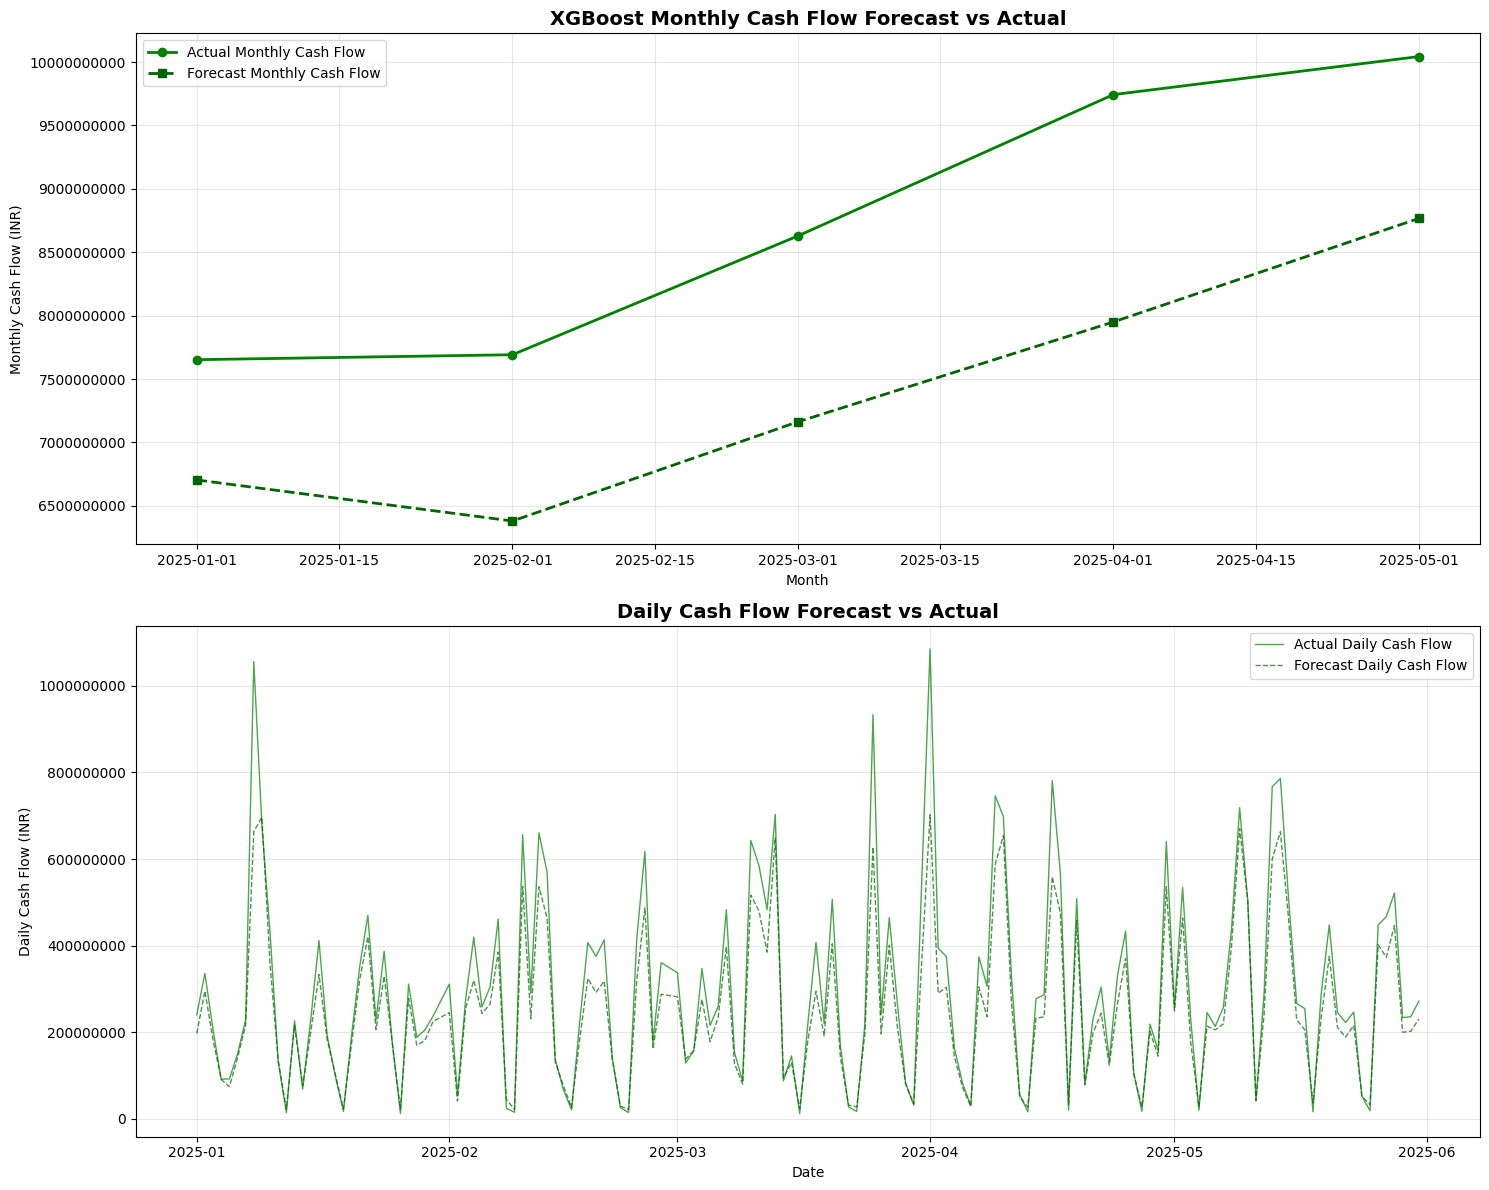


📈 Cash Flow Forecast Performance Metrics:
MAE (Mean Absolute Error): ₹1,358,886,116.84
RMSE (Root Mean Square Error): ₹1,386,363,374.09
MAPE (Mean Absolute Percentage Error): 15.51%
✅ Cash Flow Forecast Accuracy: 84.49%


📊 Top 15 Most Important Features for Cash Flow Prediction:
| feature                  |   importance |
|:-------------------------|-------------:|
| cashflow_rolling_mean_90 |       0.1784 |
| cashflow_ratio_to_max    |       0.1672 |
| cashflow_rolling_std_90  |       0.1301 |
| historical_dow_cashflow  |       0.1079 |
| cashflow_rolling_min_90  |       0.0707 |
| cashflow_ratio_to_min    |       0.0465 |
| cashflow_rolling_max_7   |       0.0368 |
| cashflow_rolling_max_90  |       0.0338 |
| cashflow_rolling_mean_7  |       0.0303 |
| month                    |       0.0281 |
| cashflow_rolling_mean_30 |       0.0264 |
| cashflow_growth_30d      |       0.0205 |
| cashflow_rolling_std_7   |       0.014  |
| days_since_start         |       0.0138 |
| cashflow_gro

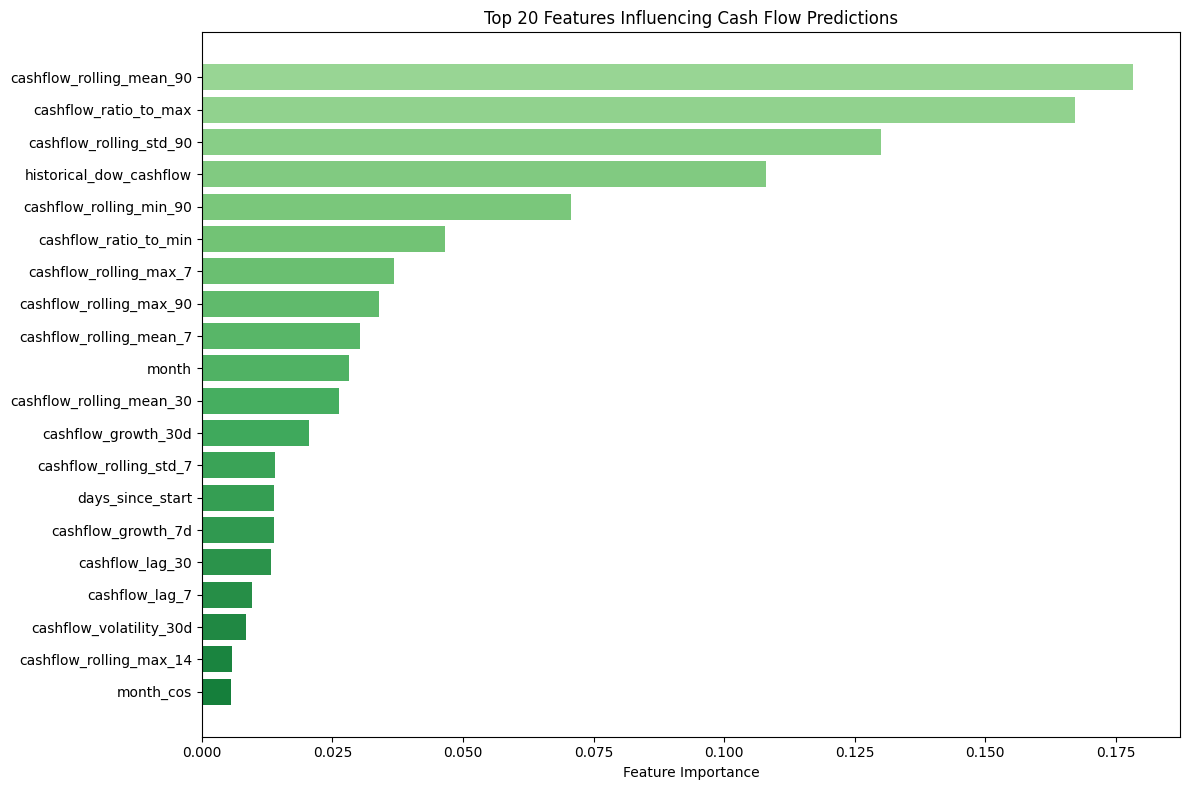

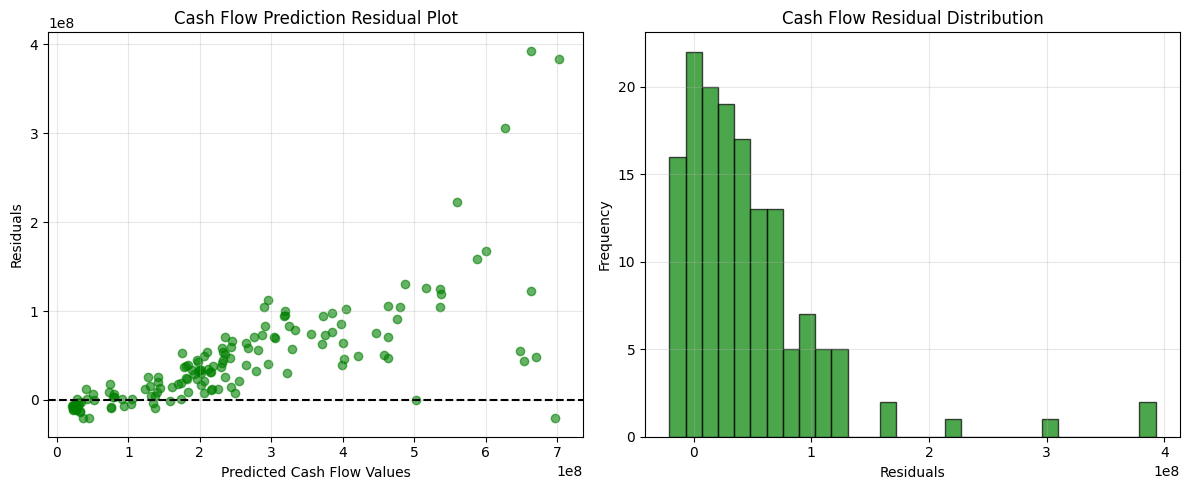


📊 Cash Flow Residual Statistics:
Mean Residual: ₹45,908,311.15
Std Residual: ₹62,396,614.82
Min Residual: ₹-20,619,499.58
Max Residual: ₹392,559,496.04

💡 Cash Flow Forecasting Insights:
Total Actual Cash Flow: ₹43,758,758,008.22
Total Forecast Cash Flow: ₹36,964,327,424.00
Total Difference: ₹6,794,430,584.22
✅ Good cash flow forecast accuracy!

🎯 Cash Flow Model is ready to predict future cash flows!
Use this model for: Liquidity management, Investment planning, Financial strategy


In [ ]:
# CASH FLOW FORECASTING MODEL - FIXED VERSION
# Predicts company cash flow using XGBoost

# IMPORTANT: Please ensure you have the following Python libraries installed
# in your environment BEFORE running this script:
# - openpyxl
# - xgboost
# - scikit-learn
# - pandas
# - numpy
# - matplotlib
# - tabulate

# STEP 1: Upload file
from google.colab import files

print("Please upload your 'loadshare_predictive_analytics (6)_processed (1).xlsx' file.")
uploaded = files.upload()

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 3: Load Data
if not uploaded:
    print("No file was uploaded. Please upload the required file to proceed.")
    raise ValueError("No file uploaded. Cannot proceed with analysis.")

file_path = list(uploaded.keys())[0]
print(f"File '{file_path}' uploaded successfully.")

try:
    # Attempt to load as Excel first, as the original file was .xlsx
    df = pd.read_excel(file_path, engine="openpyxl")
    print("Successfully loaded file as an Excel file.")
except Exception as e:
    print(f"Error loading the file as an Excel file: {e}")
    print("Attempting to load as CSV instead...")
    try:
        df = pd.read_csv(file_path)
        print("Successfully loaded file as CSV.")
    except Exception as csv_e:
        print(f"Error loading the file as CSV: {csv_e}")
        print("Please ensure the file is correctly formatted (Excel or CSV) and named.")
        raise RuntimeError("Failed to load data from the provided file. Check format and content.")

print("\n📋 Dataset Overview:")
print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nAccount Base Types available: {df['Account Base Type'].unique()}")
print(f"Currency Codes available: {df['Currency Code'].unique()}")

# Check for 'Cash Flow - Type' and 'Cash Flow Type'
if 'Cash Flow - Type' in df.columns:
    print(f"Cash Flow - Type values available: {df['Cash Flow - Type'].unique()}")
if 'Cash Flow Type' in df.columns:
    print(f"Cash Flow Type values available: {df['Cash Flow Type'].unique()}")

# STEP 4: Filter for Cash Flow records and prepare amount
# Use 'Credit - Debit' as the amount value
# Filter by non-null values in 'Cash Flow - Type' or 'Cash Flow Type'
cashflow_df = df[df['Cash Flow - Type'].notna() | df['Cash Flow Type'].notna()].copy()

print(f"\n💰 Cash Flow Data Overview:")
print(f"Total cash flow records: {len(cashflow_df):,}")

if len(cashflow_df) == 0:
    print("❌ No cash flow records found! Please ensure your data has non-null values in 'Cash Flow - Type' or 'Cash Flow Type' columns.")
    raise ValueError("No relevant cash flow data found. Cannot proceed with forecasting.")
else:
    # FIX: Handle different date formats properly
    print("Processing transaction dates...")

    # Try to detect and parse the date format
    sample_dates = cashflow_df['Transaction Date'].dropna().head(5)
    print(f"Sample dates: {sample_dates.tolist()}")

    try:
        # First try DD/MM/YYYY format (dayfirst=True)
        cashflow_df['Transaction Date'] = pd.to_datetime(cashflow_df['Transaction Date'], dayfirst=True, errors='coerce')
        print("✅ Successfully parsed dates using DD/MM/YYYY format")
    except:
        try:
            # If that fails, try mixed format
            cashflow_df['Transaction Date'] = pd.to_datetime(cashflow_df['Transaction Date'], format='mixed', dayfirst=True, errors='coerce')
            print("✅ Successfully parsed dates using mixed format")
        except:
            # Last resort - infer format
            cashflow_df['Transaction Date'] = pd.to_datetime(cashflow_df['Transaction Date'], infer_datetime_format=True, errors='coerce')
            print("✅ Successfully parsed dates using inferred format")

    # Remove rows with invalid dates
    initial_count = len(cashflow_df)
    cashflow_df = cashflow_df.dropna(subset=['Transaction Date'])
    final_count = len(cashflow_df)

    if initial_count != final_count:
        print(f"⚠️ Removed {initial_count - final_count} rows with invalid dates")

    # Use 'Credit - Debit' as the amount for cash flow
    cashflow_df['Credit - Debit'] = pd.to_numeric(cashflow_df['Credit - Debit'], errors='coerce')
    cashflow_df.dropna(subset=['Credit - Debit'], inplace=True)
    cashflow_df['Cash Flow Amount'] = cashflow_df['Credit - Debit'].abs() # Use absolute for total flow

    print(f"Date range: {cashflow_df['Transaction Date'].min()} to {cashflow_df['Transaction Date'].max()}")
    print(f"Total cash flow amount: ₹{cashflow_df['Cash Flow Amount'].sum():,.2f}")
    print(f"Average daily cash flow: ₹{cashflow_df['Cash Flow Amount'].mean():,.2f}")

# STEP 5: Daily aggregation with data quality checks
daily_cashflow = cashflow_df.groupby('Transaction Date')['Cash Flow Amount'].sum().reset_index()
daily_cashflow.columns = ['ds', 'y']
daily_cashflow = daily_cashflow[daily_cashflow['ds'] >= '2015-01-01'].copy() # Adjust start date if needed

# Remove extreme outliers (beyond 3 standard deviations)
if len(daily_cashflow) > 1 and daily_cashflow['y'].std() > 0:
    mean_val = daily_cashflow['y'].mean()
    std_val = daily_cashflow['y'].std()
    daily_cashflow = daily_cashflow[np.abs(daily_cashflow['y'] - mean_val) <= 3 * std_val].copy()

print(f"\n📊 Daily Cash Flow Summary:")
print(f"Total days with cash flow: {len(daily_cashflow):,}")
print(f"Average daily cash flow: ₹{daily_cashflow['y'].mean():,.2f}")
print(f"Median daily cash flow: ₹{daily_cashflow['y'].median():,.2f}")
print(f"Max daily cash flow: ₹{daily_cashflow['y'].max():,.2f}")

# STEP 6: Enhanced Feature Engineering for Cash Flow
def create_cashflow_features(df_input):
    df_temp = df_input.copy()

    # Basic date features
    df_temp['day'] = df_temp['ds'].dt.day
    df_temp['month'] = df_temp['ds'].dt.month
    df_temp['year'] = df_temp['ds'].dt.year
    df_temp['dayofweek'] = df_temp['ds'].dt.dayofweek
    df_temp['quarter'] = df_temp['ds'].dt.quarter

    # Cyclical encoding for seasonal cash flow patterns
    df_temp['month_sin'] = np.sin(2 * np.pi * df_temp['month'] / 12)
    df_temp['month_cos'] = np.cos(2 * np.pi * df_temp['month'] / 12)
    df_temp['day_sin'] = np.sin(2 * np.pi * df_temp['day'] / 31)
    df_temp['day_cos'] = np.cos(2 * np.pi * df_temp['day'] / 31)
    df_temp['dayofweek_sin'] = np.sin(2 * np.pi * df_temp['dayofweek'] / 7)
    df_temp['dayofweek_cos'] = np.cos(2 * np.pi * df_temp['dayofweek'] / 7)

    # Business calendar features
    df_temp['is_month_end'] = df_temp['ds'].dt.is_month_end.astype(int)
    df_temp['is_month_start'] = df_temp['ds'].dt.is_month_start.astype(int)
    df_temp['is_quarter_end'] = df_temp['ds'].dt.is_quarter_end.astype(int)
    df_temp['is_year_end'] = ((df_temp['month'] == 12) & (df_temp['day'] >= 25)).astype(int)
    df_temp['is_fy_end'] = (df_temp['month'] == 3).astype(int) # Financial year end in India
    df_temp['is_weekend'] = (df_temp['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df_temp['days_from_month_start'] = df_temp['day'] - 1
    df_temp['days_to_month_end'] = df_temp['ds'].dt.days_in_month - df_temp['day']

    # Lag features (cash flow history patterns)
    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
        df_temp[f'cashflow_lag_{lag}'] = df_temp['y'].shift(lag)

    # Rolling statistics for cash flow trends
    for window in [7, 14, 30, 90]:
        df_temp[f'cashflow_rolling_mean_{window}'] = df_temp['y'].rolling(window, min_periods=1).mean().shift(1)
        df_temp[f'cashflow_rolling_std_{window}'] = df_temp['y'].rolling(window, min_periods=1).std().shift(1)
        df_temp[f'cashflow_rolling_max_{window}'] = df_temp['y'].rolling(window, min_periods=1).max().shift(1)
        df_temp[f'cashflow_rolling_min_{window}'] = df_temp['y'].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    df_temp['historical_month_cashflow'] = df_temp.groupby('month')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_quarter_cashflow'] = df_temp.groupby('quarter')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_dow_cashflow'] = df_temp.groupby('dayofweek')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Cash flow volatility features
    df_temp['cashflow_volatility_7d'] = df_temp['y'].rolling(7).std().shift(1)
    df_temp['cashflow_volatility_30d'] = df_temp['y'].rolling(30).std().shift(1)

    # Cash flow growth rates - Handle division by zero
    df_temp['cashflow_growth_7d'] = ((df_temp['y'] / df_temp['y'].shift(7).replace(0, np.nan)) - 1) * 100
    df_temp['cashflow_growth_30d'] = ((df_temp['y'] / df_temp['y'].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df_temp['days_since_start'] = (df_temp['ds'] - df_temp['ds'].min()).dt.days

    # Cash flow ratios and patterns - Handle division by zero
    epsilon = 1e-6
    df_temp['cashflow_ratio_to_max'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).max().shift(1) + epsilon)
    df_temp['cashflow_ratio_to_min'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).min().shift(1) + epsilon)

    return df_temp

# Apply feature engineering
daily_cashflow_features = create_cashflow_features(daily_cashflow)

# FIX: Use newer pandas methods for filling NaN values
daily_cashflow_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_cashflow_features.fillna(method='bfill', inplace=True)
daily_cashflow_features.fillna(method='ffill', inplace=True)
daily_cashflow_features.fillna(0, inplace=True)

# STEP 7: Split train/test
train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < '2025-01-01'].copy()
test_cashflow = daily_cashflow_features[(daily_cashflow_features['ds'] >= '2025-01-01') &
                                      (daily_cashflow_features['ds'] <= '2025-05-31')].copy()

# Select features (excluding target and date columns)
feature_cols_cashflow = [col for col in daily_cashflow_features.columns if col not in ['ds', 'y']]

print(f"\n🎯 Model Training Setup (Cash Flow):")
print(f"Training data shape: {train_cashflow.shape}")
print(f"Test data shape: {test_cashflow.shape}")
print(f"Number of features: {len(feature_cols_cashflow)}")

if len(test_cashflow) == 0:
    print("❌ No test data available for 2025. Adjusting date range...")
    # Use last 6 months as test data if no 2025 data exists
    test_start_date_cashflow = daily_cashflow_features['ds'].max() - pd.DateOffset(months=6)
    train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < test_start_date_cashflow].copy()
    test_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] >= test_start_date_cashflow].copy()
    print(f"Adjusted - Training until: {test_start_date_cashflow}")
    print(f"Testing from: {test_start_date_cashflow} to {daily_cashflow_features['ds'].max()}")

if train_cashflow.empty or test_cashflow.empty:
    raise ValueError("Insufficient data for training or testing after splitting. Please check your dataset and date ranges.")

# STEP 8: Train Cash Flow forecasting model
model_cashflow = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("🚀 Training cash flow forecasting model...")
model_cashflow.fit(train_cashflow[feature_cols_cashflow], train_cashflow['y'])

# STEP 9: Make cash flow predictions
test_pred_cashflow = test_cashflow.copy()
test_pred_cashflow['cashflow_forecast'] = model_cashflow.predict(test_cashflow[feature_cols_cashflow])
test_pred_cashflow['cashflow_forecast'] = test_pred_cashflow['cashflow_forecast'].clip(lower=0) # Ensure predictions are non-negative

# STEP 10: Monthly aggregation for comparison
monthly_actual_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['y'].sum()
monthly_forecast_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['cashflow_forecast'].sum()

# STEP 11: Calculate cash flow forecast metrics
def safe_mape(actual, forecast):
    mask = actual != 0
    if mask.sum() == 0:
        return 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mae_cashflow = mean_absolute_error(monthly_actual_cashflow, monthly_forecast_cashflow)
rmse_cashflow = np.sqrt(mean_squared_error(monthly_actual_cashflow, monthly_forecast_cashflow))
mape_cashflow = safe_mape(monthly_actual_cashflow.values, monthly_forecast_cashflow.values)
accuracy_cashflow = 100 - mape_cashflow

# STEP 12: Create monthly cash flow comparison table
comparison_df_cashflow = pd.concat([monthly_actual_cashflow, monthly_forecast_cashflow], axis=1)
comparison_df_cashflow.columns = ['Actual Cash Flow (INR)', 'Forecast Cash Flow (INR)']
comparison_df_cashflow['Error'] = comparison_df_cashflow['Actual Cash Flow (INR)'] - comparison_df_cashflow['Forecast Cash Flow (INR)']
comparison_df_cashflow['Absolute % Error'] = (comparison_df_cashflow['Error'].abs() /
                                              comparison_df_cashflow['Actual Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
comparison_df_cashflow.index = comparison_df_cashflow.index.to_timestamp()

print("\n💸 Monthly Cash Flow Forecast Summary Table:")
print(comparison_df_cashflow.round(2).to_markdown(index=True))

# NEW STEP: Daily Cash Flow Comparison Table
print("\n🗓️ Daily Cash Flow Forecast Summary Table:")
daily_comparison_df_cashflow = test_pred_cashflow[['ds', 'y', 'cashflow_forecast']].copy()
daily_comparison_df_cashflow.columns = ['Date', 'Actual Daily Cash Flow (INR)', 'Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Error'] = daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'] - daily_comparison_df_cashflow['Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Absolute % Error'] = (daily_comparison_df_cashflow['Error'].abs() /
                                                   daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
print(daily_comparison_df_cashflow.round(2).to_markdown(index=False))

# STEP 13: Cash Flow Visualization
fig_cashflow, (ax1_cashflow, ax2_cashflow) = plt.subplots(2, 1, figsize=(15, 12))

# Monthly cash flow comparison
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Actual Cash Flow (INR)'],
         label='Actual Monthly Cash Flow', color='green', linewidth=2, marker='o')
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Forecast Cash Flow (INR)'],
         label='Forecast Monthly Cash Flow', color='darkgreen', linewidth=2,
         linestyle='--', marker='s')
ax1_cashflow.set_title("XGBoost Monthly Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax1_cashflow.set_xlabel("Month")
ax1_cashflow.set_ylabel("Monthly Cash Flow (INR)")
ax1_cashflow.legend()
ax1_cashflow.grid(True, alpha=0.3)
ax1_cashflow.ticklabel_format(style='plain', axis='y')

# Daily cash flow comparison for detailed view
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['y'], label='Actual Daily Cash Flow',
         color='green', alpha=0.7, linewidth=1)
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['cashflow_forecast'], label='Forecast Daily Cash Flow',
         color='darkgreen', alpha=0.7, linewidth=1, linestyle='--')
ax2_cashflow.set_title("Daily Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax2_cashflow.set_xlabel("Date")
ax2_cashflow.set_ylabel("Daily Cash Flow (INR)")
ax2_cashflow.legend()
ax2_cashflow.grid(True, alpha=0.3)
ax2_cashflow.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# STEP 14: Cash Flow forecast performance metrics
print(f"\n📈 Cash Flow Forecast Performance Metrics:")
print(f"MAE (Mean Absolute Error): ₹{mae_cashflow:,.2f}")
print(f"RMSE (Root Mean Square Error): ₹{rmse_cashflow:,.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_cashflow:.2f}%")
print(f"✅ Cash Flow Forecast Accuracy: {accuracy_cashflow:.2f}%\n")

# STEP 15: Feature importance analysis for Cash Flow
feature_importance_cashflow = pd.DataFrame({
    'feature': feature_cols_cashflow,
    'importance': model_cashflow.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features for Cash Flow Prediction:")
print(feature_importance_cashflow.head(15).round(4).to_markdown(index=False))

# Plot cash flow feature importance
plt.figure(figsize=(12, 8))
top_features_cashflow = feature_importance_cashflow.head(20)
colors_cashflow = plt.cm.Greens(np.linspace(0.4, 0.8, len(top_features_cashflow)))
plt.barh(range(len(top_features_cashflow)), top_features_cashflow['importance'], color=colors_cashflow)
plt.yticks(range(len(top_features_cashflow)), top_features_cashflow['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Influencing Cash Flow Predictions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 16: Cash Flow residual analysis
residuals_cashflow = test_pred_cashflow['y'] - test_pred_cashflow['cashflow_forecast']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_pred_cashflow['cashflow_forecast'], residuals_cashflow, alpha=0.6, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Cash Flow Values')
plt.ylabel('Residuals')
plt.title('Cash Flow Prediction Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals_cashflow, bins=30, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Cash Flow Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Cash Flow Residual Statistics:")
print(f"Mean Residual: ₹{residuals_cashflow.mean():,.2f}")
print(f"Std Residual: ₹{residuals_cashflow.std():,.2f}")
print(f"Min Residual: ₹{residuals_cashflow.min():,.2f}")
print(f"Max Residual: ₹{residuals_cashflow.max():,.2f}")

# STEP 17: Summary insights
print(f"\n💡 Cash Flow Forecasting Insights:")
total_actual_cashflow = monthly_actual_cashflow.sum()
total_forecast_cashflow = monthly_forecast_cashflow.sum()
print(f"Total Actual Cash Flow: ₹{total_actual_cashflow:,.2f}")
print(f"Total Forecast Cash Flow: ₹{total_forecast_cashflow:,.2f}")
print(f"Total Difference: ₹{abs(total_actual_cashflow - total_forecast_cashflow):,.2f}")

if accuracy_cashflow > 70:
    print("✅ Good cash flow forecast accuracy!")
elif accuracy_cashflow > 50:
    print("⚠️ Moderate cash flow forecast accuracy - consider more data or features")
else:
    print("❌ Low cash flow forecast accuracy - model needs improvement")

print(f"\n🎯 Cash Flow Model is ready to predict future cash flows!")
print(f"Use this model for: Liquidity management, Investment planning, Financial strategy")

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Step 1: Load the Excel file
def load_excel_data(file_path):
    """
    Load Excel file into pandas DataFrame
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Step 2: Process Income and Expense data - INDIVIDUAL TRANSACTIONS
def process_income_expense(df, account_type_col='account_base_type',
                          date_col='transaction_date',
                          amount_col='amount'):
    """
    Extract income and expense rows, convert each to profit entries
    """
    # Get unique account types to check available values
    unique_types = df[account_type_col].unique()
    print(f"Available account types: {unique_types}")

    # Create case-insensitive filter for income and expense
    income_expense_df = df[df[account_type_col].str.lower().isin(['income', 'expense'])].copy()

    if income_expense_df.empty:
        print("No income or expense records found!")
        print("Make sure your data contains 'Income' and 'Expense' account types")
        return None

    print(f"Found {len(income_expense_df)} income/expense records")
    print(f"Income records: {len(income_expense_df[income_expense_df[account_type_col].str.lower() == 'income'])}")
    print(f"Expense records: {len(income_expense_df[income_expense_df[account_type_col].str.lower() == 'expense'])}")

    # Ensure date column is datetime
    income_expense_df[date_col] = pd.to_datetime(income_expense_df[date_col])

    # Convert each income/expense row to profit calculation
    # Income = positive profit, Expense = negative profit
    income_expense_df['profit'] = income_expense_df.apply(
        lambda row: row[amount_col] if row[account_type_col].lower() == 'income'
                   else -row[amount_col] if row[account_type_col].lower() == 'expense'
                   else 0, axis=1
    )

    print(f"Profit calculation completed for {len(income_expense_df)} individual transactions")
    print(f"Total profit: {income_expense_df['profit'].sum():.2f}")
    print(f"Positive profits (income): {len(income_expense_df[income_expense_df['profit'] > 0])}")
    print(f"Negative profits (expense): {len(income_expense_df[income_expense_df['profit'] < 0])}")

    return income_expense_df

# Step 3: Prepare profit rows for merging
def create_profit_rows(income_expense_df, date_col='transaction_date', original_df_columns=None):
    """
    Convert each income/expense transaction to profit rows maintaining original structure
    """
    if income_expense_df is None or income_expense_df.empty:
        return pd.DataFrame()

    profit_rows = []

    for _, row in income_expense_df.iterrows():
        # Create profit row maintaining original column structure
        profit_row = {}

        # Copy relevant columns from original row
        if original_df_columns:
            for col in original_df_columns:
                if col in row.index:
                    profit_row[col] = row[col]

        # Override specific columns for profit entry
        profit_row[date_col] = row[date_col]
        profit_row['Account Base Type'] = 'Profit'
        profit_row['Credit - Debit'] = row['profit']
        profit_row['Account Name'] = f"Profit from {row.get('Account Name', 'Transaction')} - {row[date_col].strftime('%Y-%m-%d')}"
        profit_row['Account Type'] = 'Profit'

        profit_rows.append(profit_row)

    profit_df = pd.DataFrame(profit_rows)
    print(f"Created {len(profit_df)} individual profit rows")
    print(f"Total profit amount: {profit_df['Credit - Debit'].sum():.2f}")

    return profit_df

# Step 4: Merge back with assets and liabilities
def merge_with_assets_liabilities_equity(original_df, profit_df, account_type_col='account_base_type'):
    """
    Filter assets, liabilities, and equity from original data and append profit rows
    """
    # Filter assets, liabilities, and equity (case-insensitive)
    balance_sheet_df = original_df[
        original_df[account_type_col].str.lower().isin(['asset', 'liability', 'assets', 'liabilities', 'equity'])
    ].copy()

    print(f"Found {len(balance_sheet_df)} asset/liability/equity records")
    print(f"Breakdown: {balance_sheet_df[account_type_col].value_counts()}")

    # Append profit rows
    final_df = pd.concat([balance_sheet_df, profit_df], ignore_index=True)

    print(f"Final dataset shape: {final_df.shape}")
    print(f"Account types in final dataset: {final_df[account_type_col].value_counts()}")

    return final_df

# Main processing function
def process_cashflow_data(file_path,
                         account_type_col='account_base_type',
                         date_col='transaction_date',
                         amount_col='amount',
                         credit_debit_col='credit_debit'):
    """
    Complete processing pipeline for cashflow data preparation
    """
    print("=== Starting Cashflow Data Processing ===\n")

    # Step 1: Load data
    df = load_excel_data(file_path)
    if df is None:
        return None

    # Display initial data info
    print(f"\nInitial data overview:")
    print(f"Account types: {df[account_type_col].value_counts()}")

    # Step 2: Process income and expense - INDIVIDUAL TRANSACTIONS
    income_expense_data = process_income_expense(df, account_type_col, date_col, amount_col)
    if income_expense_data is None:
        return None

    # Step 3: Create individual profit rows for each income/expense transaction
    profit_rows_df = create_profit_rows(income_expense_data, date_col, df.columns.tolist())
    print(f"\nCreated {len(profit_rows_df)} individual profit rows (should match income + expense count)")
    print(f"Expected: {len(income_expense_data)} profit rows")

    # Step 4: Merge with assets, liabilities, and equity
    final_cashflow_df = merge_with_assets_liabilities_equity(df, profit_rows_df, account_type_col)

    print("\n=== Processing Complete ===")
    return final_cashflow_df, income_expense_data

# Usage example and helper functions
def save_results(final_df, profit_table, output_path='cashflow_data.xlsx'):
    """
    Save the processed data to Excel file
    """
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        final_df.to_excel(writer, sheet_name='Cashflow_Data', index=False)
        profit_table.to_excel(writer, sheet_name='Profit_Summary', index=False)

    print(f"Results saved to {output_path}")

def display_summary(final_df, account_type_col='account_base_type'):
    """
    Display summary statistics of the final dataset
    """
    print("\n=== FINAL DATASET SUMMARY ===")
    print(f"Total records: {len(final_df)}")
    print(f"\nAccount type distribution:")
    print(final_df[account_type_col].value_counts())

    if 'credit_debit' in final_df.columns:
        print(f"\nCredit/Debit summary:")
        print(f"Total Credits: {final_df['credit_debit'].sum():.2f}")
        print(f"Non-zero entries: {(final_df['credit_debit'] != 0).sum()}")

# Google Colab File Upload and Processing
def upload_and_process_excel():
    """
    Upload Excel file in Google Colab and process it
    """
    from google.colab import files
    import os

    print("Please upload your Excel file:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return None, None

    # Get the uploaded file path
    file_name = list(uploaded.keys())[0]
    file_path = f"/content/{file_name}"

    print(f"File uploaded: {file_name}")

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found at {file_path}")
        return None, None

    # Load and inspect the data first
    try:
        df = pd.read_excel(file_path)
        print(f"\nFile loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\nFirst few rows:")
        print(df.head())

        # Show unique values in account type column (if it exists)
        possible_account_cols = [col for col in df.columns if 'account' in col.lower() or 'type' in col.lower()]
        if possible_account_cols:
            print(f"\nPossible account type columns: {possible_account_cols}")
            for col in possible_account_cols:
                print(f"\nUnique values in '{col}': {df[col].unique()}")

        return file_path, df

    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None, None

# Interactive setup function
def interactive_setup():
    """
    Interactive setup to identify correct column names
    """
    file_path, df = upload_and_process_excel()

    if df is None:
        return None, None

    print("\n" + "="*50)
    print("COLUMN IDENTIFICATION")
    print("="*50)

    # Get column names from user
    print(f"Available columns: {list(df.columns)}")

    account_type_col = input("\nEnter the column name for account base type (contains income, expense, asset, liabilities): ").strip()
    date_col = input("Enter the column name for transaction date: ").strip()
    amount_col = input("Enter the column name for amount/value: ").strip()

    # Validate columns exist
    missing_cols = []
    for col_name, col_var in [("Account type", account_type_col), ("Date", date_col), ("Amount", amount_col)]:
        if col_var not in df.columns:
            missing_cols.append(f"{col_name}: '{col_var}'")

    if missing_cols:
        print(f"\nError: The following columns were not found:")
        for missing in missing_cols:
            print(f"  - {missing}")
        print(f"\nAvailable columns: {list(df.columns)}")
        return None, None

    # Show data preview with selected columns
    print(f"\nData preview with selected columns:")
    print(df[[account_type_col, date_col, amount_col]].head())

    # Check account types
    print(f"\nUnique account types found: {df[account_type_col].unique()}")

    return file_path, {
        'account_type_col': account_type_col,
        'date_col': date_col,
        'amount_col': amount_col
    }

# Main execution function for Google Colab
def run_cashflow_processing():
    """
    Main function to run the entire cashflow processing pipeline
    """
    print("=== CASHFLOW DATA PROCESSING ===\n")

    # Interactive setup
    file_path, column_config = interactive_setup()

    if file_path is None or column_config is None:
        print("Setup failed. Please try again.")
        return

    # Process the data
    try:
        result = process_cashflow_data(
            file_path=file_path,
            account_type_col=column_config['account_type_col'],
            date_col=column_config['date_col'],
            amount_col=column_config['amount_col']
        )

        if result is None:
            print("Processing failed!")
            return

        final_df, profit_summary = result

        # Display summary
        display_summary(final_df, column_config['account_type_col'])

        # Save results
        output_file = 'processed_cashflow_data.xlsx'
        save_results(final_df, profit_summary, output_file)

        # Display first few rows
        print("\nFirst 10 rows of final dataset:")
        print(final_df.head(10))

        # Download the processed file
        from google.colab import files
        files.download(output_file)

        print(f"\n✅ Processing complete! Downloaded: {output_file}")

        return final_df, profit_summary

    except Exception as e:
        print(f"Error during processing: {e}")
        return None

# Quick start function
def quick_start_with_defaults(file_path):
    """
    Quick start with common default column names
    """
    common_configs = [
        {'account_type_col': 'account_base_type', 'date_col': 'transaction_date', 'amount_col': 'amount'},
        {'account_type_col': 'Account Type', 'date_col': 'Date', 'amount_col': 'Amount'},
        {'account_type_col': 'account_type', 'date_col': 'date', 'amount_col': 'value'},
    ]

    df = pd.read_excel(file_path)
    print(f"Columns in your file: {list(df.columns)}")

    for i, config in enumerate(common_configs):
        missing = [col for col in config.values() if col not in df.columns]
        if not missing:
            print(f"✅ Using configuration {i+1}: {config}")
            return process_cashflow_data(file_path, **config)
        else:
            print(f"❌ Configuration {i+1} missing columns: {missing}")

    print("No matching configuration found. Please use interactive_setup() or run_cashflow_processing()")
    return None

# Example usage
if __name__ == "__main__":
    # Run the complete interactive processing
    run_cashflow_processing()

=== CASHFLOW DATA PROCESSING ===

Please upload your Excel file:


Saving Predictive_Analytics_Locus.xlsx to Predictive_Analytics_Locus.xlsx
File uploaded: Predictive_Analytics_Locus.xlsx

File loaded successfully!
Shape: (30232, 10)
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

First few rows:
   Credit - Debit Currency Code  Debit - Credit Zoho Module Transaction Date  \
0        -1117.86           USD         1117.86     journal       2025-05-31   
1          669.24           USD         -669.24     journal       2025-05-31   
2          702.82           USD         -702.82     journal       2025-05-31   
3           -8.72           USD            8.72     journal       2025-05-31   
4         -353.88           USD          353.88     journal       2025-05-31   

                 Account Name Account Base Type     Account Type  \
0             Office supplies           Expense          Expense   
1         

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Processing complete! Downloaded: processed_cashflow_data.xlsx


Please upload your 'Predictive_Analysis_Final.xlsx - Sheet1.csv' file.


Saving processed_cashflow_data(3).xlsx to processed_cashflow_data(3).xlsx
File 'processed_cashflow_data(3).xlsx' uploaded successfully.
Successfully loaded file as an Excel file.

📋 Dataset Overview:
Total records: 30,232
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

Account Base Types available: ['Liability' 'Asset' 'Equity' 'Profit']
Currency Codes available: ['USD' 'EGP' 'IDR' 'SAR' 'GBP' 'CAD' 'AED' 'EUR' 'VND' 'INR' 'SGD' 'PKR'
 'THB' 'MYR' 'HRK']
Cash Flow - Type values available: ['-1' 'B. Cash Flow From Investing Activities'
 'A. Cash Flow From Operating Activities' '0']
Cash Flow Type values available: ['A. Cash Flow From Operating Activities' '0'
 'B. Cash Flow From Investing Activities' '-1']

💰 Cash Flow Data Overview:
Total cash flow records: 30,232
Date range: 2019-06-05 00:00:00 to 2025-06-14 00:00:00
Total cash flow amount: ₹504

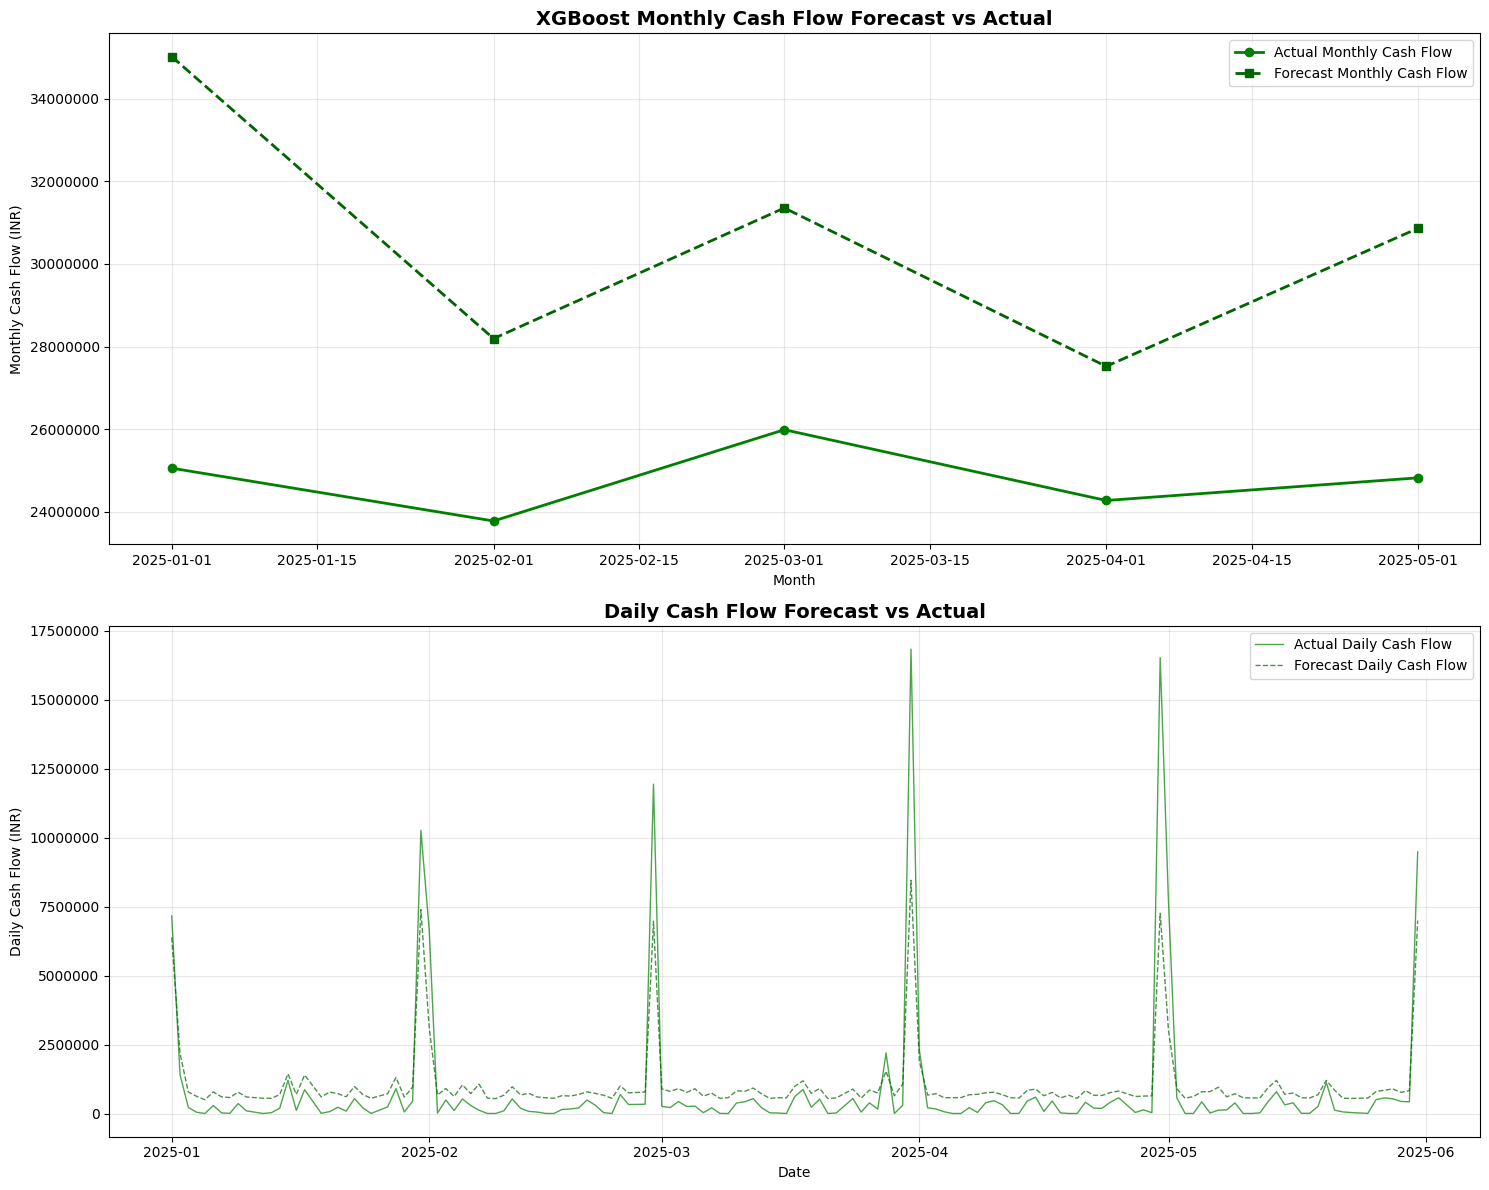


📈 Cash Flow Forecast Performance Metrics:
MAE (Mean Absolute Error): ₹5,802,843.65
RMSE (Root Mean Square Error): ₹6,234,565.91
MAPE (Mean Absolute Percentage Error): 23.32%
✅ Cash Flow Forecast Accuracy: 76.68%


📊 Top 15 Most Important Features for Cash Flow Prediction:
| feature                  |   importance |
|:-------------------------|-------------:|
| cashflow_ratio_to_max    |       0.1865 |
| cashflow_rolling_mean_30 |       0.1544 |
| day_cos                  |       0.1107 |
| cashflow_rolling_max_30  |       0.0882 |
| cashflow_rolling_mean_7  |       0.0568 |
| year                     |       0.0545 |
| quarter                  |       0.0404 |
| cashflow_ratio_to_min    |       0.036  |
| cashflow_lag_1           |       0.0355 |
| cashflow_growth_7d       |       0.0334 |
| cashflow_rolling_std_30  |       0.0209 |
| historical_dow_cashflow  |       0.0208 |
| cashflow_growth_30d      |       0.0188 |
| cashflow_lag_2           |       0.0188 |
| month_cos           

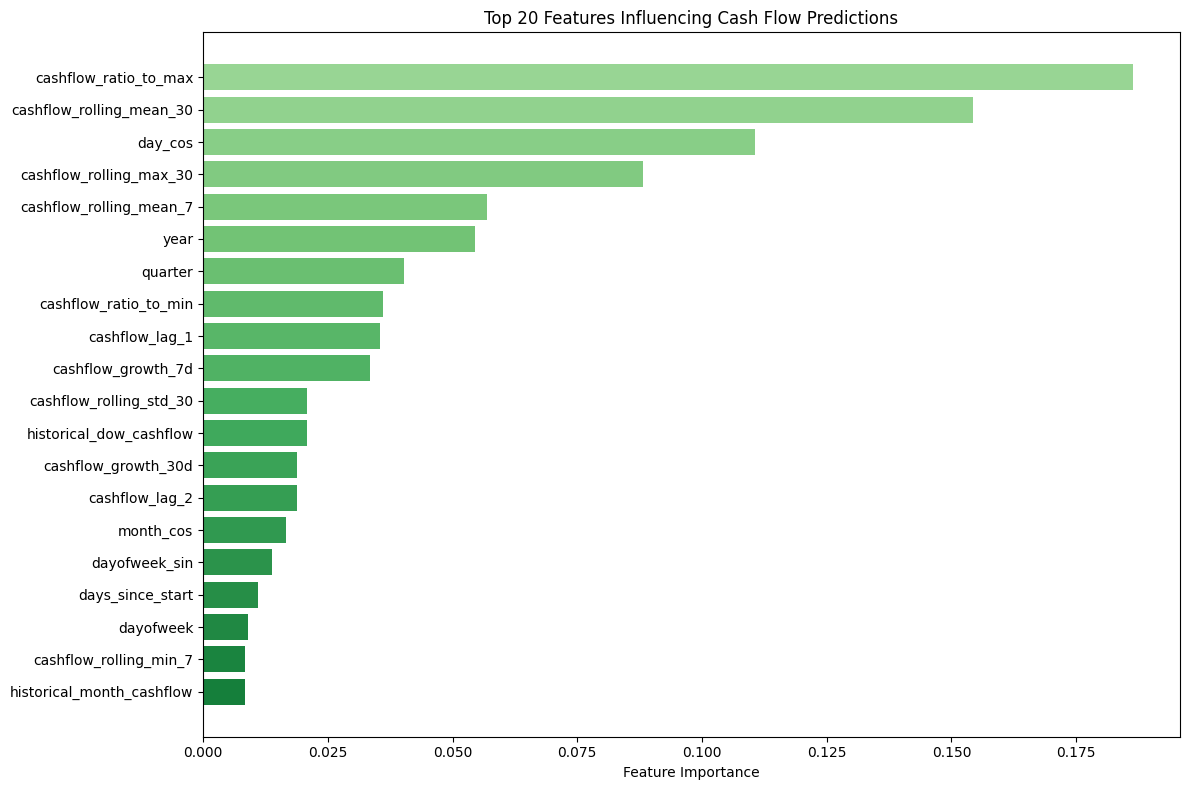

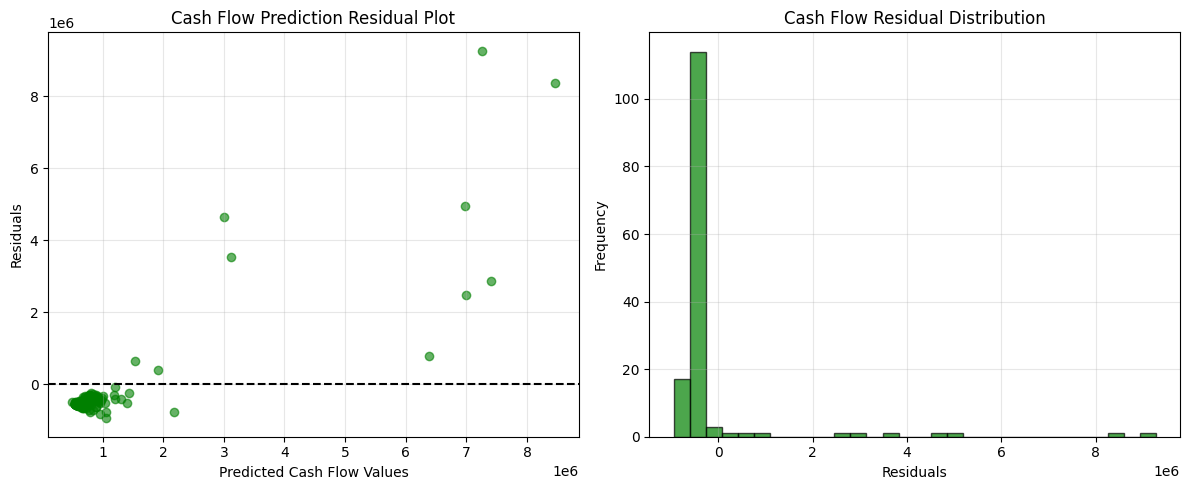


📊 Cash Flow Residual Statistics:
Mean Residual: ₹-201,487.64
Std Residual: ₹1,349,906.77
Min Residual: ₹-946,612.57
Max Residual: ₹9,271,976.84

💡 Cash Flow Forecasting Insights:
Total Actual Cash Flow: ₹123,921,833.77
Total Forecast Cash Flow: ₹152,936,048.00
Total Difference: ₹29,014,214.23
✅ Good cash flow forecast accuracy!

🎯 Cash Flow Model is ready to predict future cash flows!
Use this model for: Liquidity management, Investment planning, Financial strategy


In [ ]:
# CASH FLOW FORECASTING MODEL
# Predicts company cash flow using XGBoost

# IMPORTANT: Please ensure you have the following Python libraries installed
# in your Gemini environment BEFORE running this script:
# - openpyxl
# - xgboost
# - scikit-learn
# - pandas
# - numpy
# - matplotlib
# - tabulate
# If any are missing, you may need to install them via your environment's package manager.

# STEP 1: Upload file
from google.colab import files

print("Please upload your 'Predictive_Analysis_Final.xlsx - Sheet1.csv' file.")
uploaded = files.upload()

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 3: Load Data
if not uploaded:
    print("No file was uploaded. Please upload the required file to proceed.")
    # In a real interactive session, you might re-prompt or exit.
    # For this environment, we'll indicate an error and proceed carefully
    # or stop if no file is available to prevent further errors.
    raise ValueError("No file uploaded. Cannot proceed with analysis.")


file_path = list(uploaded.keys())[0]
print(f"File '{file_path}' uploaded successfully.")

try:
    # Attempt to load as Excel first, as the original file was .xlsx
    df = pd.read_excel(file_path, engine="openpyxl")
    print("Successfully loaded file as an Excel file.")
except Exception as e:
    print(f"Error loading the file as an Excel file: {e}")
    print("Attempting to load as CSV instead...")
    try:
        df = pd.read_csv(file_path)
        print("Successfully loaded file as CSV.")
    except Exception as csv_e:
        print(f"Error loading the file as CSV: {csv_e}")
        print("Please ensure the file is correctly formatted (Excel or CSV) and named.")
        raise RuntimeError("Failed to load data from the provided file. Check format and content.")


print("\n📋 Dataset Overview:")
print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nAccount Base Types available: {df['Account Base Type'].unique()}")
print(f"Currency Codes available: {df['Currency Code'].unique()}")
# Check for 'Cash Flow - Type' and 'Cash Flow Type'
if 'Cash Flow - Type' in df.columns:
    print(f"Cash Flow - Type values available: {df['Cash Flow - Type'].unique()}")
if 'Cash Flow Type' in df.columns:
    print(f"Cash Flow Type values available: {df['Cash Flow Type'].unique()}")


# STEP 4: Filter for Cash Flow records and prepare amount
# Use 'Credit - Debit' as the amount value
# Filter by non-null values in 'Cash Flow - Type' or 'Cash Flow Type'
cashflow_df = df[df['Cash Flow - Type'].notna() | df['Cash Flow Type'].notna()].copy()

print(f"\n💰 Cash Flow Data Overview:")
print(f"Total cash flow records: {len(cashflow_df):,}")

if len(cashflow_df) == 0:
    print("❌ No cash flow records found! Please ensure your data has non-null values in 'Cash Flow - Type' or 'Cash Flow Type' columns.")
    raise ValueError("No relevant cash flow data found. Cannot proceed with forecasting.")
else:
    cashflow_df['Transaction Date'] = pd.to_datetime(cashflow_df['Transaction Date'])
    # Use 'Credit - Debit' as the amount for cash flow
    cashflow_df['Credit - Debit'] = pd.to_numeric(cashflow_df['Credit - Debit'], errors='coerce')
    cashflow_df.dropna(subset=['Credit - Debit'], inplace=True)
    cashflow_df['Cash Flow Amount'] = cashflow_df['Credit - Debit'].abs() # Use absolute for total flow

    print(f"Date range: {cashflow_df['Transaction Date'].min()} to {cashflow_df['Transaction Date'].max()}")
    print(f"Total cash flow amount: ₹{cashflow_df['Cash Flow Amount'].sum():,.2f}")
    print(f"Average daily cash flow: ₹{cashflow_df['Cash Flow Amount'].mean():,.2f}")

# STEP 5: Daily aggregation with data quality checks
daily_cashflow = cashflow_df.groupby('Transaction Date')['Cash Flow Amount'].sum().reset_index()
daily_cashflow.columns = ['ds', 'y']
daily_cashflow = daily_cashflow[daily_cashflow['ds'] >= '2015-01-01'].copy() # Adjust start date if needed

# Remove extreme outliers (beyond 3 standard deviations)
if len(daily_cashflow) > 1 and daily_cashflow['y'].std() > 0:
    mean_val = daily_cashflow['y'].mean()
    std_val = daily_cashflow['y'].std()
    daily_cashflow = daily_cashflow[np.abs(daily_cashflow['y'] - mean_val) <= 3 * std_val].copy()

print(f"\n📊 Daily Cash Flow Summary:")
print(f"Total days with cash flow: {len(daily_cashflow):,}")
print(f"Average daily cash flow: ₹{daily_cashflow['y'].mean():,.2f}")
print(f"Median daily cash flow: ₹{daily_cashflow['y'].median():,.2f}")
print(f"Max daily cash flow: ₹{daily_cashflow['y'].max():,.2f}")

# STEP 6: Enhanced Feature Engineering for Cash Flow
def create_cashflow_features(df_input):
    df_temp = df_input.copy()

    # Basic date features
    df_temp['day'] = df_temp['ds'].dt.day
    df_temp['month'] = df_temp['ds'].dt.month
    df_temp['year'] = df_temp['ds'].dt.year
    df_temp['dayofweek'] = df_temp['ds'].dt.dayofweek
    df_temp['quarter'] = df_temp['ds'].dt.quarter

    # Cyclical encoding for seasonal cash flow patterns
    df_temp['month_sin'] = np.sin(2 * np.pi * df_temp['month'] / 12)
    df_temp['month_cos'] = np.cos(2 * np.pi * df_temp['month'] / 12)
    df_temp['day_sin'] = np.sin(2 * np.pi * df_temp['day'] / 31)
    df_temp['day_cos'] = np.cos(2 * np.pi * df_temp['day'] / 31)
    df_temp['dayofweek_sin'] = np.sin(2 * np.pi * df_temp['dayofweek'] / 7)
    df_temp['dayofweek_cos'] = np.cos(2 * np.pi * df_temp['dayofweek'] / 7)

    # Business calendar features
    df_temp['is_month_end'] = df_temp['ds'].dt.is_month_end.astype(int)
    df_temp['is_month_start'] = df_temp['ds'].dt.is_month_start.astype(int)
    df_temp['is_quarter_end'] = df_temp['ds'].dt.is_quarter_end.astype(int)
    df_temp['is_year_end'] = ((df_temp['month'] == 12) & (df_temp['day'] >= 25)).astype(int)
    df_temp['is_fy_end'] = (df_temp['month'] == 3).astype(int) # Financial year end in India
    df_temp['is_weekend'] = (df_temp['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df_temp['days_from_month_start'] = df_temp['day'] - 1
    df_temp['days_to_month_end'] = df_temp['ds'].dt.days_in_month - df_temp['day']

    # Lag features (cash flow history patterns)
    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
        df_temp[f'cashflow_lag_{lag}'] = df_temp['y'].shift(lag)

    # Rolling statistics for cash flow trends
    for window in [7, 14, 30, 90]:
        df_temp[f'cashflow_rolling_mean_{window}'] = df_temp['y'].rolling(window, min_periods=1).mean().shift(1)
        df_temp[f'cashflow_rolling_std_{window}'] = df_temp['y'].rolling(window, min_periods=1).std().shift(1)
        df_temp[f'cashflow_rolling_max_{window}'] = df_temp['y'].rolling(window, min_periods=1).max().shift(1)
        df_temp[f'cashflow_rolling_min_{window}'] = df_temp['y'].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    df_temp['historical_month_cashflow'] = df_temp.groupby('month')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_quarter_cashflow'] = df_temp.groupby('quarter')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df_temp['historical_dow_cashflow'] = df_temp.groupby('dayofweek')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Cash flow volatility features
    df_temp['cashflow_volatility_7d'] = df_temp['y'].rolling(7).std().shift(1)
    df_temp['cashflow_volatility_30d'] = df_temp['y'].rolling(30).std().shift(1)

    # Cash flow growth rates - Handle division by zero
    df_temp['cashflow_growth_7d'] = ((df_temp['y'] / df_temp['y'].shift(7).replace(0, np.nan)) - 1) * 100
    df_temp['cashflow_growth_30d'] = ((df_temp['y'] / df_temp['y'].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df_temp['days_since_start'] = (df_temp['ds'] - df_temp['ds'].min()).dt.days

    # Cash flow ratios and patterns - Handle division by zero
    epsilon = 1e-6
    df_temp['cashflow_ratio_to_max'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).max().shift(1) + epsilon)
    df_temp['cashflow_ratio_to_min'] = df_temp['y'] / (df_temp['y'].rolling(365, min_periods=30).min().shift(1) + epsilon)

    return df_temp

# Apply feature engineering
daily_cashflow_features = create_cashflow_features(daily_cashflow)

# Critical: Replace inf values with NaN and then fill NaNs.
daily_cashflow_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_cashflow_features.fillna(method='bfill', inplace=True)
daily_cashflow_features.fillna(method='ffill', inplace=True)
daily_cashflow_features.fillna(0, inplace=True)

# STEP 7: Split train/test
train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < '2025-01-01'].copy()
test_cashflow = daily_cashflow_features[(daily_cashflow_features['ds'] >= '2025-01-01') &
                                      (daily_cashflow_features['ds'] <= '2025-05-31')].copy()

# Select features (excluding target and date columns)
feature_cols_cashflow = [col for col in daily_cashflow_features.columns if col not in ['ds', 'y']]

print(f"\n🎯 Model Training Setup (Cash Flow):")
print(f"Training data shape: {train_cashflow.shape}")
print(f"Test data shape: {test_cashflow.shape}")
print(f"Number of features: {len(feature_cols_cashflow)}")

if len(test_cashflow) == 0:
    print("❌ No test data available for 2025. Adjusting date range...")
    # Use last 6 months as test data if no 2025 data exists
    test_start_date_cashflow = daily_cashflow_features['ds'].max() - pd.DateOffset(months=6)
    train_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] < test_start_date_cashflow].copy()
    test_cashflow = daily_cashflow_features[daily_cashflow_features['ds'] >= test_start_date_cashflow].copy()
    print(f"Adjusted - Training until: {test_start_date_cashflow}")
    print(f"Testing from: {test_start_date_cashflow} to {daily_cashflow_features['ds'].max()}")

if train_cashflow.empty or test_cashflow.empty:
    raise ValueError("Insufficient data for training or testing after splitting. Please check your dataset and date ranges.")

# STEP 8: Train Cash Flow forecasting model
model_cashflow = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("🚀 Training cash flow forecasting model...")
model_cashflow.fit(train_cashflow[feature_cols_cashflow], train_cashflow['y'])

# STEP 9: Make cash flow predictions
test_pred_cashflow = test_cashflow.copy()
test_pred_cashflow['cashflow_forecast'] = model_cashflow.predict(test_cashflow[feature_cols_cashflow])
test_pred_cashflow['cashflow_forecast'] = test_pred_cashflow['cashflow_forecast'].clip(lower=0) # Ensure predictions are non-negative

# STEP 10: Monthly aggregation for comparison
monthly_actual_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['y'].sum()
monthly_forecast_cashflow = test_pred_cashflow.groupby(test_pred_cashflow['ds'].dt.to_period('M'))['cashflow_forecast'].sum()

# STEP 11: Calculate cash flow forecast metrics
def safe_mape(actual, forecast):
    mask = actual != 0
    if mask.sum() == 0:
        return 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mae_cashflow = mean_absolute_error(monthly_actual_cashflow, monthly_forecast_cashflow)
rmse_cashflow = np.sqrt(mean_squared_error(monthly_actual_cashflow, monthly_forecast_cashflow))
mape_cashflow = safe_mape(monthly_actual_cashflow.values, monthly_forecast_cashflow.values)
accuracy_cashflow = 100 - mape_cashflow

# STEP 12: Create monthly cash flow comparison table
comparison_df_cashflow = pd.concat([monthly_actual_cashflow, monthly_forecast_cashflow], axis=1)
comparison_df_cashflow.columns = ['Actual Cash Flow (INR)', 'Forecast Cash Flow (INR)']
comparison_df_cashflow['Error'] = comparison_df_cashflow['Actual Cash Flow (INR)'] - comparison_df_cashflow['Forecast Cash Flow (INR)']
comparison_df_cashflow['Absolute % Error'] = (comparison_df_cashflow['Error'].abs() /
                                              comparison_df_cashflow['Actual Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
comparison_df_cashflow.index = comparison_df_cashflow.index.to_timestamp()

print("\n💸 Monthly Cash Flow Forecast Summary Table:")
print(comparison_df_cashflow.round(2).to_markdown(index=True))

# NEW STEP: Daily Cash Flow Comparison Table
print("\n🗓️ Daily Cash Flow Forecast Summary Table:")
daily_comparison_df_cashflow = test_pred_cashflow[['ds', 'y', 'cashflow_forecast']].copy()
daily_comparison_df_cashflow.columns = ['Date', 'Actual Daily Cash Flow (INR)', 'Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Error'] = daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'] - daily_comparison_df_cashflow['Forecast Daily Cash Flow (INR)']
daily_comparison_df_cashflow['Absolute % Error'] = (daily_comparison_df_cashflow['Error'].abs() /
                                                   daily_comparison_df_cashflow['Actual Daily Cash Flow (INR)'].replace(0, np.nan).abs()) * 100
print(daily_comparison_df_cashflow.round(2).to_markdown(index=False))

# STEP 13: Cash Flow Visualization (Optional - user requested table, but good to keep visualization code for reference)
# The user specifically requested a table, but we will still show the plots as a comprehensive output.
# If you only want tables, you can comment out the plt.show() lines.
fig_cashflow, (ax1_cashflow, ax2_cashflow) = plt.subplots(2, 1, figsize=(15, 12))

# Monthly cash flow comparison
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Actual Cash Flow (INR)'],
         label='Actual Monthly Cash Flow', color='green', linewidth=2, marker='o')
ax1_cashflow.plot(comparison_df_cashflow.index, comparison_df_cashflow['Forecast Cash Flow (INR)'],
         label='Forecast Monthly Cash Flow', color='darkgreen', linewidth=2,
         linestyle='--', marker='s')
ax1_cashflow.set_title("XGBoost Monthly Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax1_cashflow.set_xlabel("Month")
ax1_cashflow.set_ylabel("Monthly Cash Flow (INR)")
ax1_cashflow.legend()
ax1_cashflow.grid(True, alpha=0.3)
ax1_cashflow.ticklabel_format(style='plain', axis='y')

# Daily cash flow comparison for detailed view
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['y'], label='Actual Daily Cash Flow',
         color='green', alpha=0.7, linewidth=1)
ax2_cashflow.plot(test_pred_cashflow['ds'], test_pred_cashflow['cashflow_forecast'], label='Forecast Daily Cash Flow',
         color='darkgreen', alpha=0.7, linewidth=1, linestyle='--')
ax2_cashflow.set_title("Daily Cash Flow Forecast vs Actual", fontsize=14, fontweight='bold')
ax2_cashflow.set_xlabel("Date")
ax2_cashflow.set_ylabel("Daily Cash Flow (INR)")
ax2_cashflow.legend()
ax2_cashflow.grid(True, alpha=0.3)
ax2_cashflow.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# STEP 14: Cash Flow forecast performance metrics
print(f"\n📈 Cash Flow Forecast Performance Metrics:")
print(f"MAE (Mean Absolute Error): ₹{mae_cashflow:,.2f}")
print(f"RMSE (Root Mean Square Error): ₹{rmse_cashflow:,.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_cashflow:.2f}%")
print(f"✅ Cash Flow Forecast Accuracy: {accuracy_cashflow:.2f}%\n")

# STEP 15: Feature importance analysis for Cash Flow
feature_importance_cashflow = pd.DataFrame({
    'feature': feature_cols_cashflow,
    'importance': model_cashflow.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features for Cash Flow Prediction:")
print(feature_importance_cashflow.head(15).round(4).to_markdown(index=False))

# Plot cash flow feature importance
plt.figure(figsize=(12, 8))
top_features_cashflow = feature_importance_cashflow.head(20)
colors_cashflow = plt.cm.Greens(np.linspace(0.4, 0.8, len(top_features_cashflow)))
plt.barh(range(len(top_features_cashflow)), top_features_cashflow['importance'], color=colors_cashflow)
plt.yticks(range(len(top_features_cashflow)), top_features_cashflow['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Influencing Cash Flow Predictions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 16: Cash Flow residual analysis
residuals_cashflow = test_pred_cashflow['y'] - test_pred_cashflow['cashflow_forecast']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_pred_cashflow['cashflow_forecast'], residuals_cashflow, alpha=0.6, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Cash Flow Values')
plt.ylabel('Residuals')
plt.title('Cash Flow Prediction Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals_cashflow, bins=30, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Cash Flow Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Cash Flow Residual Statistics:")
print(f"Mean Residual: ₹{residuals_cashflow.mean():,.2f}")
print(f"Std Residual: ₹{residuals_cashflow.std():,.2f}")
print(f"Min Residual: ₹{residuals_cashflow.min():,.2f}")
print(f"Max Residual: ₹{residuals_cashflow.max():,.2f}")

# STEP 17: Summary insights
print(f"\n💡 Cash Flow Forecasting Insights:")
total_actual_cashflow = monthly_actual_cashflow.sum()
total_forecast_cashflow = monthly_forecast_cashflow.sum()
print(f"Total Actual Cash Flow: ₹{total_actual_cashflow:,.2f}")
print(f"Total Forecast Cash Flow: ₹{total_forecast_cashflow:,.2f}")
print(f"Total Difference: ₹{abs(total_actual_cashflow - total_forecast_cashflow):,.2f}")

if accuracy_cashflow > 70:
    print("✅ Good cash flow forecast accuracy!")
elif accuracy_cashflow > 50:
    print("⚠️ Moderate cash flow forecast accuracy - consider more data or features")
else:
    print("❌ Low cash flow forecast accuracy - model needs improvement")

print(f"\n🎯 Cash Flow Model is ready to predict future cash flows!")
print(f"Use this model for: Liquidity management, Investment planning, Financial strategy")
